<a href="https://colab.research.google.com/github/matthew9671/MattLab/blob/main/Revisiting_SVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- [ ] Implement and test Kalman filtering and smoothing with parallel scan
- [ ] Write analysis code for pendulum
  - [x] Evaluate predictive accuracy
  - [ ] Do linear regression from latents to angle and velocity 

In [ ]:
# This reloads files not modules
%load_ext autoreload
%autoreload 2

In [ ]:
# @title Download stuff 
import os
# Download and install the relevant libraries
!pip install -q ml-collections git+https://github.com/google/flax
!pip install -q wandb

     |████████████████████████████████| 77 kB 3.5 MB/s 
     |████████████████████████████████| 145 kB 28.0 MB/s 
     |████████████████████████████████| 8.3 MB 77.8 MB/s 
     |████████████████████████████████| 237 kB 84.3 MB/s 
     |████████████████████████████████| 51 kB 8.3 MB/s 
     |████████████████████████████████| 85 kB 5.4 MB/s 
     |████████████████████████████████| 1.9 MB 4.8 MB/s 
     |████████████████████████████████| 182 kB 77.7 MB/s 
     |████████████████████████████████| 166 kB 72.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 166 kB 79.1 MB/s 
     |████████████████████████████████| 162 kB 84.3 MB/s 
     |████████████████████████████████| 162 kB 77.3 MB/s 
     |████████████████████████████████| 158 kB 76.9 MB/s 
     |████████████████████████████████| 157 kB 79.1 MB/s 
     |████████████████████████████████| 157 kB 84.0 MB/s 
     |████████████████████████████████| 157 kB 85.9 MB/s 
     |█████████████████

# Set up everything

In [ ]:
# @title Imports
# Misc
import os
from importlib import reload
import numpy as onp
import matplotlib.pyplot as plt
from functools import partial
from tqdm import trange
import copy, traceback
from pprint import pprint
from copy import deepcopy
import pickle as pkl

# for logging
import wandb
# Debug
import pdb
# Jax
import jax
from jax import vmap, lax, jit, value_and_grad
import jax.numpy as np
import jax.scipy as scipy
import jax.random as jr
key_0 = jr.PRNGKey(0) # Convenience
from jax.lax import scan, stop_gradient
from jax.tree_util import tree_map
# optax
import optax as opt
# Flax
import flax.linen as nn
from flax.linen import Conv, ConvTranspose
from flax.core import frozen_dict as fd

# Tensorflow probability
import tensorflow_probability.substrates.jax as tfp
import tensorflow_probability.substrates.jax.distributions as tfd
# Common math functions
from flax.linen import softplus, sigmoid
from jax.scipy.special import logsumexp
from jax.scipy.linalg import solve_triangular
from jax.numpy.linalg import eigh, cholesky, svd, inv

# For typing in neural network utils
from typing import (NamedTuple, Any, Callable, Sequence, Iterable, List, Optional, Tuple,
                    Set, Type, Union, TypeVar, Generic, Dict)

# For making the pendulum dataset
from PIL import Image
from PIL import ImageDraw

# For making nice visualizations
from sklearn.decomposition import PCA
from IPython.display import clear_output, HTML
from matplotlib import animation, rc
import seaborn as sns
color_names = ["windows blue",
                "red",
                "amber",
                "faded green",
                "dusty purple",
                "orange",
                "clay",
                "pink",
                "greyish",
                "mint",
                "light cyan",
                "steel blue",
                "forest green",
                "pastel purple",
                "salmon",
                "dark brown",
               "violet",
               "mauve",
               "ocean",
               "ugly yellow"]
colors = sns.xkcd_palette(color_names)

# Get rid of the check types warning
import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [ ]:
# @title Misc helpers
def get_value(x):
    try:
        return x.val.val.primal
    except:
        try:
            return x.val.val
        except:
            try:
                return x.val
            except:
                return x  # Oh well.

def plot_img_grid(recon):
    plt.figure(figsize=(8,8))
    # Show the sequence as a block of images
    stacked = recon.reshape(10, 24 * 10, 24)
    imgrid = stacked.swapaxes(0, 1).reshape(24 * 10, 24 * 10)
    plt.imshow(imgrid, vmin=0, vmax=1)

In [ ]:
# @title Math helpers
def softplus(x):
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def inv_softplus(x, eps=1e-4):
    return np.log(np.exp(x - eps) - 1)

def vectorize_pytree(*args):
    """
    Flatten an arbitrary PyTree into a vector.
    :param args:
    :return:
    """
    flat_tree, _ = jax.tree_util.tree_flatten(args)
    flat_vs = [x.flatten() for x in flat_tree]
    return np.concatenate(flat_vs, axis=0)

# converts an (n(n+1)/2,) vector of Lie parameters
# to an (n, n) matrix
def lie_params_to_constrained(out_flat, dim, eps=1e-4):
    D, A = out_flat[:dim], out_flat[dim:]
    # ATTENTION: we changed this!
    # D = np.maximum(softplus(D), eps)
    D = softplus(D) + eps
    # Build a skew-symmetric matrix
    S = np.zeros((dim, dim))
    i1, i2 = np.tril_indices(dim - 1)
    S = S.at[i1+1, i2].set(A)
    S = S.T
    S = S.at[i1+1, i2].set(-A)

    O = scipy.linalg.expm(S)
    J = O.T @ np.diag(D) @ O
    return J

# converts an (n, n) matrix 
# to an (n, n) matrix with singular values in (0, 1)
def get_constrained_dynamics(A):
    dim = A.shape[0]
    diag = np.diag(A)
    diag = sigmoid(diag)
    # Build a skew-symmetric matrix
    S = np.zeros((dim, dim))
    i1, i2 = np.tril_indices(dim - 1)
    S = S.at[i1+1, i2].set(A[i1+1, i2])
    S = S.T
    S = S.at[i1+1, i2].set(-A[i1+1, i2])
    U = scipy.linalg.expm(S)

    S = np.zeros((dim, dim))
    i1, i2 = np.tril_indices(dim - 1)
    S = S.at[i1+1, i2].set(A.T[i1+1, i2])
    S = S.T
    S = S.at[i1+1, i2].set(-A.T[i1+1, i2])
    V = scipy.linalg.expm(S)

    A = U @ np.diag(diag) @ V
    return A, U, V

def scale_singular_values(A):
    _, s, _ = svd(A)
    return A / (np.maximum(1, np.max(s)))

def truncate_singular_values(A):
    u, s, vt = svd(A)
    return u @ np.diag(np.clip(s, 0, 1)) @ vt

# Assume that h has a batch shape here
def sample_info_gaussian(seed, J, h):
    # Avoid inversion.
    # see https://github.com/mattjj/pybasicbayes/blob/master/pybasicbayes/util/stats.py#L117-L122
    L = np.linalg.cholesky(J)
    x = jr.normal(key=seed, shape=h.shape)
    return solve_triangular(L,x.T,lower=True,trans='T').T \
        + np.linalg.solve(J,h.T).T

def sample_info_gaussian_old(seed, J, h):
    cov = np.linalg.inv(J)
    loc = np.einsum("...ij,...j->...i", cov, h)
    return tfp.distributions.MultivariateNormalFullCovariance(
        loc=loc, covariance_matrix=cov).sample(sample_shape=(), seed=seed)

In [ ]:
# # @title Kalman filtering and smoothing
# def block_tridiag_mvn_log_normalizer(J_diag, J_lower_diag, h):
#     # extract dimensions
#     num_timesteps, dim = J_diag.shape[:2]

#     # Pad the L's with one extra set of zeros for the last predict step
#     J_lower_diag_pad = np.concatenate((J_lower_diag, 
#                                        np.zeros((1, dim, dim))), axis=0)

#     def marginalize(carry, t):
#         Jp, hp, lp = carry

#         # Condition
#         Jc = J_diag[t] + Jp
#         hc = h[t] + hp

#         # Predict -- Cholesky approach seems unstable!
#         # sqrt_Jc = np.linalg.cholesky(Jc)
#         # trm1 = solve_triangular(sqrt_Jc, hc, lower=True)
#         # trm2 = solve_triangular(sqrt_Jc, J_lower_diag_pad[t].T, lower=True)
#         # log_Z = 0.5 * dim * np.log(2 * np.pi)
#         # log_Z += -np.sum(np.log(np.diag(sqrt_Jc)))  # sum these terms only to get approx log|J|
#         # log_Z += 0.5 * np.dot(trm1.T, trm1)
#         # Jp = -np.dot(trm2.T, trm2)
#         # hp = -np.dot(trm2.T, trm1)

#         # Alternative predict step:
#         log_Z = 0.5 * dim * np.log(2 * np.pi)
#         log_Z += -0.5 * np.linalg.slogdet(Jc)[1]
#         log_Z += 0.5 * np.dot(hc, np.linalg.solve(Jc, hc))
#         Jp = -np.dot(J_lower_diag_pad[t], np.linalg.solve(Jc, J_lower_diag_pad[t].T))
#         Jp = (Jp + Jp.T) * .5   # Manual symmetrization
#         hp = -np.dot(J_lower_diag_pad[t], np.linalg.solve(Jc, hc))

#         new_carry = Jp, hp, lp + log_Z
#         return new_carry, (Jc, hc)

#     # Initialize
#     Jp0 = np.zeros((dim, dim))
#     hp0 = np.zeros((dim,))

#     (_, _, log_Z), (filtered_Js, filtered_hs) = lax.scan(marginalize, 
#                             (Jp0, hp0, 0), np.arange(num_timesteps))
#     return log_Z, (filtered_Js, filtered_hs)


In [ ]:
# @title Parallel scan version

# TODO: implement this
# Basically, we want a function that takes in (J, L, h) and outputs (log_Z, J_filtered, h_filtered)
# However the original parallel Kalman works on (A, b, Q)

In [ ]:
# @title Experiment scheduler
LINE_SEP = "#" * 42

def dict_len(d):
    if (type(d) == list):
        return len(d)
    else:
        return dict_len(d[list(d.keys())[0]])

def dict_map(d, func):
    if type(d) == list:
        return func(d)
    elif type(d) == dict:
        r = copy.deepcopy(d)
        for key in d.keys():
            r[key] = dict_map(r[key], func)
            # Ignore all the Nones
            if r[key] is None:
                r.pop(key)
        if len(r.keys()) == 0:
            # There's no content
            return None
        else:
            return r
    else:
        return None

def dict_product(d1, d2):
    l1, l2 = dict_len(d1), dict_len(d2)
    def expand_list(d):
        result = []
        for item in d:
            result.append(item)
            result.extend([None] * (l2-1))
        return result
    def multiply_list(d):
        return d * l1
    result = dict_map(d1, expand_list)
    additions = dict_map(d2, multiply_list)
    return dict_update(result, additions)

def dict_get(d, id):
    return dict_map(d, lambda l: l[id])

def dict_update(d, u):
    if d is None:
        d = dict()
    for key in u.keys():
        if type(u[key]) == dict:
            d.update({
                key: dict_update(d.get(key), u[key])
            })
        else:
            d.update({key: u[key]})
    return d

# A standardized function that structures and schedules experiments
# Can chain multiple variations of experiment parameters together
def experiment_scheduler(run_params, dataset_getter, model_getter, train_func, 
                         logger_func=None, err_logger_func=None, 
                         run_variations=None, params_expander=None,
                         on_error=None, continue_on_error=True, use_wandb=True):
    """
    Arguments:
        run_params: dict{"dataset_params"} 
            A large dictionary containing all relevant parameters to the run 
        dataset_getter: run_params -> dict{"train_data", ["generative_model"]}
            A function that loads/samples a dataset
        model_getter: run_params, data_dict -> model
            A function that creates a model given parameters. Note that the model
            could depend on the specifics of the dataset/generative model as well
        train_func: model, data, run_params -> results
            A function that contains the training loop. 
            TODO: later we might wanna open up this pipeline and customize further!
        (optional) logger_func: results, run_params -> ()
            A function that logs the current run.
        (optional) err_logger_func: message, run_params -> ()
            A function that is called when the run fails.
        (optional) run_variations: dict{}
            A nested dictionary where the leaves are lists of different parameters.
            None means no change from parameters of the last run.
        (optional) params_expander: dict{} -> dict{}
            Turns high level parameters into specific low level parameters.
    returns:
        all_results: List<result>
            A list containing results from all runs. Failed runs are indicated
            with a None value.
    """
    params_expander = params_expander or (lambda d: d)

    num_runs = dict_len(run_variations) if run_variations else 1
    params = copy.deepcopy(run_params)
    print("Total number of runs: {}".format(num_runs))
    print("Base paramerters:")
    pprint(params)

    global data_dict
    all_results = []
    all_models = []

    def _single_run(data_out, model_out):
        print("Loading dataset!")
        data_dict = dataset_getter(curr_params)
        data_out.append(data_dict)
        # Make a new model
        model_dict = model_getter(curr_params, data_dict)
        model_out.append(model_dict)
        all_models.append(model_dict)
        results = train_func(model_dict, data_dict, curr_params)
        all_results.append(results)
        if logger_func:
            logger_func(results, curr_params, data_dict)

    for run in range(num_runs):
        print(LINE_SEP)
        print("Starting run #{}".format(run))
        print(LINE_SEP)
        curr_variation = dict_get(run_variations, run)
        if curr_variation is None:
            if (run != 0):
                print("Variation #{} is a duplicate, skipping run.".format(run))
                continue
            curr_params = params_expander(params)
        else:
            print("Current parameter variation:")
            pprint(curr_variation)
            curr_params = dict_update(params, curr_variation)
            curr_params = params_expander(curr_params)
            print("Current full parameters:")
            pprint(curr_params)
            if curr_variation.get("dataset_params"):
                reload_data = True
        # Hack to get the values even when they err out
        data_out = []
        model_out = []
        if not continue_on_error:
            _single_run(data_out, model_out)
        else:
            try:
                _single_run(data_out, model_out)
                if use_wandb: wandb.finish()
            except:
                all_results.append(None)
                if (on_error): 
                    try:
                        on_error(data_out[0], model_out[0])
                    except:
                        pass # Oh well...
                print("Run errored out due to some the following reason:")
                traceback.print_exc()
                if use_wandb: wandb.finish(exit_code=1)
    return all_results, all_models

## Define the base SVAE object

In [ ]:
class SVAE:
    def __init__(self,
                 recognition=None, decoder=None, prior=None, posterior=None,
                 input_dummy=None, latent_dummy=None):
        """
        rec_net, dec_net, prior are all objects that take in parameters
        rec_net.apply(params, data) returns Gaussian potentials (parameters)
        dec_net.apply(params, latents) returns probability distributions
        prior : SVAEPrior
        """
        self.recognition = recognition
        self.decoder = decoder
        self.prior = prior
        self.posterior = posterior
        self.input_dummy = input_dummy
        self.latent_dummy = latent_dummy

    def init(self, key=None):
        if key is None:
            key = jr.PRNGKey(0)

        rec_key, dec_key, prior_key, post_key = jr.split(key, 4)

        return {
            "rec_params": self.recognition.init(rec_key, self.input_dummy),
            "dec_params": self.decoder.init(dec_key, self.latent_dummy),
            "prior_params": self.prior.init(prior_key),
            "post_params": self.posterior.init(post_key)
        }

    def kl_posterior_prior(self, posterior_params, prior_params, 
                           samples=None):
        posterior = self.posterior.distribution(posterior_params)
        prior = self.prior.distribution(prior_params)
        if samples is None:
            return posterior.kl_divergence(prior)
        else:
            return np.mean(posterior.log_prob(samples) - prior.log_prob(samples))

    def elbo(self, key, data, model_params, sample_kl=False, **params):
        rec_params = model_params["rec_params"]
        dec_params = model_params["dec_params"]
        prior_params = self.prior.get_constrained_params(model_params["prior_params"])

        # Mask out a large window of states
        mask_size = params.get("mask_size")
        T = data.shape[0]
        mask = onp.ones((T,))
        key, dropout_key = jr.split(key)
        if mask_size:
            # Potential dropout...!
            # Use a trick to generate the mask without indexing with a tracer
            start_id = jr.choice(dropout_key, T - mask_size + 1)
            mask = np.array(np.arange(T) >= start_id) \
                 * np.array(np.arange(T) < start_id + mask_size)
            mask = 1 - mask
            if params.get("mask_type") == "potential":
                # This only works with svaes
                potential = self.recognition.apply(rec_params, data)
                potential = tree_map(
                    lambda t: np.einsum("i,i...->i...", mask[:t.shape[0]], t), potential)
            else:
                potential = self.recognition.apply(rec_params, 
                                                   np.einsum("t...,t->t...", data, mask))
        else:
            # Don't do any masking
            potential = self.recognition.apply(rec_params, data)

        # Update: it makes more sense that inference is done in the posterior object
        posterior_params = self.posterior.infer(prior_params, potential)
        
        # Take samples under the posterior
        num_samples = params.get("obj_samples") or 1
        samples = self.posterior.sample(posterior_params, (num_samples,), key)
        # and compute average ll

        def likelihood_outputs(latent):
            likelihood_dist = self.decoder.apply(dec_params, latent)
            return likelihood_dist.mean(), likelihood_dist.log_prob(data)

        mean, ells = vmap(likelihood_outputs)(samples)
        # Take average over samples then sum the rest
        ell = np.sum(np.mean(ells, axis=0))
        # Compute kl from posterior to prior
        if sample_kl:
            kl = self.kl_posterior_prior(posterior_params, prior_params, 
                                         samples=samples)
        else:
            kl = self.kl_posterior_prior(posterior_params, prior_params)

        elbo = ell - kl

        return {
            "elbo": elbo,
            "ell": ell,
            "kl": kl,
            "posterior_params": posterior_params,
            "posterior_samples": samples,
            "reconstruction": mean,
            "mask": mask
        }

    def compute_objective(self, key, data, model_params, **params):
        results = self.elbo(key, data, model_params, **params)
        results["objective"] = results["elbo"]
        return results

In [ ]:
# @title The DeepLDS object (implements custom kl function)
class DeepLDS(SVAE):
    def kl_posterior_prior(self, posterior_params, prior_params, 
                           samples=None):
        posterior = self.posterior.distribution(posterior_params)
        prior = self.prior.distribution(prior_params)
        if samples is None:
            Ex = posterior.expected_states
            ExxT = posterior.expected_states_squared
            ExnxT = posterior.expected_states_next_states
            Sigmatt = ExxT - np.einsum("ti,tj->tij", Ex, Ex)
            Sigmatnt = ExnxT - np.einsum("ti,tj->tji", Ex[:-1], Ex[1:])

            J, L = prior_params["J"], prior_params["L"]

            cross_entropy = -prior.log_prob(Ex)
            cross_entropy += 0.5 * np.einsum("tij,tij->", J, Sigmatt) 
            cross_entropy += np.einsum("tij,tij->", L, Sigmatnt)
            return cross_entropy - posterior.entropy()
            
        else:
            return np.mean(posterior.log_prob(samples) - prior.log_prob(samples))

In [ ]:
# @title SVAE Prior object
class SVAEPrior:
    def init(self, key):
        """
        Returns the initial prior parameters.
        """
        pass

    def distribution(self, prior_params):
        """
        Returns a tfp distribution object
        Takes constrained params
        """
        pass

    def m_step(self, prior_params, posterior, post_params):
        """
        Returns updated prior parameters.
        """
        pass
    
    def sample(self, params, shape, key):
        return self.distribution(
            self.get_constrained_params(params)).sample(shape, seed=key)

    def get_constrained_params(self, params):
        return deepcopy(params)

    @property
    def shape(self):
        raise NotImplementedError

## Important distributions

In [439]:
# @title MVN tridiag object (taken from ssm)
from tensorflow_probability.python.internal import reparameterization

def block_tridiag_mvn_log_normalizer(J_diag, J_lower_diag, h):
    """ TODO
    """
    # extract dimensions
    num_timesteps, dim = J_diag.shape[:2]

    # Pad the L's with one extra set of zeros for the last predict step
    J_lower_diag_pad = np.concatenate((J_lower_diag, np.zeros((1, dim, dim))), axis=0)

    def marginalize(carry, t):
        Jp, hp, lp = carry

        # Condition
        Jc = J_diag[t] + Jp
        hc = h[t] + hp

        # Predict -- Cholesky approach seems unstable!
        sqrt_Jc = np.linalg.cholesky(Jc)
        trm1 = solve_triangular(sqrt_Jc, hc, lower=True)
        trm2 = solve_triangular(sqrt_Jc, J_lower_diag_pad[t].T, lower=True)
        log_Z = 0.5 * dim * np.log(2 * np.pi)
        log_Z += -np.sum(np.log(np.diag(sqrt_Jc)))  # sum these terms only to get approx log|J|
        log_Z += 0.5 * np.dot(trm1.T, trm1)
        Jp = -np.dot(trm2.T, trm2)
        hp = -np.dot(trm2.T, trm1)

        # Alternative predict step:
        # log_Z = 0.5 * dim * np.log(2 * np.pi)
        # log_Z += -0.5 * np.linalg.slogdet(Jc)[1]
        # log_Z += 0.5 * np.dot(hc, np.linalg.solve(Jc, hc))
        # Jp = -np.dot(J_lower_diag_pad[t], np.linalg.solve(Jc, J_lower_diag_pad[t].T))
        # # Jp = (Jp + Jp.T) * .5   # Manual symmetrization
        # hp = -np.dot(J_lower_diag_pad[t], np.linalg.solve(Jc, hc))

        new_carry = Jp, hp, lp + log_Z
        return new_carry, (Jc, hc)

    # Initialize
    Jp0 = np.zeros((dim, dim))
    hp0 = np.zeros((dim,))
    (_, _, log_Z), (filtered_Js, filtered_hs) = lax.scan(marginalize, (Jp0, hp0, 0), np.arange(num_timesteps))
    return log_Z, (filtered_Js, filtered_hs)

class MultivariateNormalBlockTridiag(tfd.Distribution):
    """
    The Gaussian linear dynamical system's posterior distribution over latent states
    is a multivariate normal distribution whose _precision_ matrix is
    block tridiagonal.

        x | y ~ N(\mu, \Sigma)

    where

        \Sigma^{-1} = J = [[J_{0,0},   J_{0,1},   0,       0,      0],
                           [J_{1,0},   J_{1,1},   J_{1,2}, 0,      0],
                           [0,         J_{2,1},   J_{2,2}, \ddots, 0],
                           [0,         0,         \ddots,  \ddots,  ],

    is block tridiagonal, and J_{t, t+1} = J_{t+1, t}^T.

    The pdf is

        p(x) = exp \{-1/2 x^T J x + x^T h - \log Z(J, h) \}
             = exp \{- 1/2 \sum_{t=1}^T x_t^T J_{t,t} x_t
                     - \sum_{t=1}^{T-1} x_{t+1}^T J_{t+1,t} x_t
                     + \sum_{t=1}^T x_t^T h_t
                     -\log Z(J, h)\}

    where J = \Sigma^{-1} and h = \Sigma^{-1} \mu = J \mu.

    Using exponential family tricks we know that

        E[x_t] = \grad_{h_t} \log Z(J, h)
        E[x_t x_t^T] = -2 \grad_{J_{t,t}} \log Z(J, h)
        E[x_{t+1} x_t^T] = -\grad_{J_{t+1,t}} \log Z(J, h)

    These are the expectations we need for EM.
    """
    def __init__(self,
                 precision_diag_blocks,
                 precision_lower_diag_blocks,
                 linear_potential,
                 log_normalizer,
                 filtered_precisions,
                 filtered_linear_potentials,
                 expected_states,
                 expected_states_squared,
                 expected_states_next_states,
                 validate_args=False,
                 allow_nan_stats=True,
                 name="MultivariateNormalBlockTridiag",
             ) -> None:

        self._precision_diag_blocks = precision_diag_blocks
        self._precision_lower_diag_blocks = precision_lower_diag_blocks
        self._linear_potential = linear_potential
        self._log_normalizer = log_normalizer
        self._filtered_precisions = filtered_precisions
        self._filtered_linear_potentials = filtered_linear_potentials
        self._expected_states = expected_states
        self._expected_states_squared = expected_states_squared
        self._expected_states_next_states = expected_states_next_states

        # We would detect the dtype dynamically but that would break vmap
        # see https://github.com/tensorflow/probability/issues/1271
        dtype = np.float32
        super(MultivariateNormalBlockTridiag, self).__init__(
            dtype=dtype,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            reparameterization_type=reparameterization.NOT_REPARAMETERIZED,
            parameters=dict(precision_diag_blocks=self._precision_diag_blocks,
                            precision_lower_diag_blocks=self._precision_lower_diag_blocks,
                            linear_potential=self._linear_potential,
                            log_normalizer=self._log_normalizer,
                            filtered_precisions=self._filtered_precisions,
                            filtered_linear_potentials=self._filtered_linear_potentials,
                            expected_states=self._expected_states,
                            expected_states_squared=self._expected_states_squared,
                            expected_states_next_states=self._expected_states_next_states),
            name=name,
        )

    @classmethod
    def _parameter_properties(cls, dtype, num_classes=None):
        # pylint: disable=g-long-lambda
        return dict(
            precision_diag_blocks=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3),
            precision_lower_diag_blocks=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3),
            linear_potential=tfp.internal.parameter_properties.ParameterProperties(event_ndims=2),
            log_normalizer=tfp.internal.parameter_properties.ParameterProperties(event_ndims=0),
            filtered_precisions=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3),
            filtered_linear_potentials=tfp.internal.parameter_properties.ParameterProperties(event_ndims=2),
            expected_states=tfp.internal.parameter_properties.ParameterProperties(event_ndims=2),
            expected_states_squared=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3),
            expected_states_next_states=tfp.internal.parameter_properties.ParameterProperties(event_ndims=3),
        )

    @classmethod
    def infer(cls,
              precision_diag_blocks,
              precision_lower_diag_blocks,
              linear_potential):
        assert precision_diag_blocks.ndim == 3
        num_timesteps, dim = precision_diag_blocks.shape[:2]
        assert precision_diag_blocks.shape[2] == dim
        assert precision_lower_diag_blocks.shape == (num_timesteps - 1, dim, dim)
        assert linear_potential.shape == (num_timesteps, dim)

        # Run message passing code to get the log normalizer, the filtering potentials,
        # and the expected values of x. Technically, the natural parameters are -1/2 J
        # so we need to do a little correction of the gradients to get the expectations.
        f = value_and_grad(block_tridiag_mvn_log_normalizer, argnums=(0, 1, 2), has_aux=True)
        (log_normalizer, (filtered_precisions, filtered_linear_potentials)), grads = \
            f(precision_diag_blocks, precision_lower_diag_blocks, linear_potential)

        # Manually symmetrize ExxT due to numerical issues...!!!
        # Correct for the -1/2 J -> J implementation
        expected_states_squared = - grads[0] - np.swapaxes(grads[0], -2, -1)
        expected_states_next_states = -grads[1]
        expected_states = grads[2]

        return cls(precision_diag_blocks,
                   precision_lower_diag_blocks,
                   linear_potential,
                   log_normalizer,
                   filtered_precisions,
                   filtered_linear_potentials,
                   expected_states,
                   expected_states_squared,
                   expected_states_next_states)

    @classmethod
    def infer_from_precision_and_mean(cls,
                                      precision_diag_blocks,
                                      precision_lower_diag_blocks,
                                      mean):
        assert precision_diag_blocks.ndim == 3
        num_timesteps, dim = precision_diag_blocks.shape[:2]
        assert precision_diag_blocks.shape[2] == dim
        assert precision_lower_diag_blocks.shape == (num_timesteps - 1, dim, dim)
        assert mean.shape == (num_timesteps, dim)

        # Convert the mean to the linear potential
        linear_potential = np.einsum('tij,tj->ti', precision_diag_blocks, mean)
        linear_potential = linear_potential.at[:-1].add(
            np.einsum('tji,tj->ti', precision_lower_diag_blocks, mean[1:]))
        linear_potential = linear_potential.at[1:].add(
            np.einsum('tij,tj->ti', precision_lower_diag_blocks, mean[:-1]))

        # Call the constructor above
        return cls.infer(precision_diag_blocks,
                         precision_lower_diag_blocks,
                         linear_potential)

    # Properties to get private class variables
    @property
    def precision_diag_blocks(self):
        return self._precision_diag_blocks

    @property
    def precision_lower_diag_blocks(self):
        return self._precision_lower_diag_blocks

    @property
    def linear_potential(self):
        return self._linear_potential

    @property
    def log_normalizer(self):
        return self._log_normalizer

    @property
    def filtered_precisions(self):
        return self._filtered_precisions

    @property
    def filtered_linear_potentials(self):
        return self._filtered_linear_potentials

    @property
    def expected_states(self):
        return self._expected_states

    @property
    def expected_states_squared(self):
        return self._expected_states_squared

    @property
    def expected_states_next_states(self):
        return self._expected_states_next_states

    def _log_prob(self, data, **kwargs):
        lp = -0.5 * np.einsum('...ti,...tij,...tj->...', data, self._precision_diag_blocks, data)
        lp += -np.einsum('...ti,...tij,...tj->...', data[...,1:,:], self._precision_lower_diag_blocks, data[...,:-1,:])
        lp += np.einsum('...ti,...ti->...', data, self._linear_potential)
        lp -= self.log_normalizer
        return lp

    def _mean(self):
        return self.expected_states

    def _covariance(self):
        """
        NOTE: This computes the _marginal_ covariance Cov[x_t] for each t
        """
        Ex = self._expected_states
        ExxT = self._expected_states_squared
        return ExxT - np.einsum("...i,...j->...ij", Ex, Ex)

    def _sample_n(self, n, seed=None):
        filtered_Js = self._filtered_precisions
        filtered_hs = self._filtered_linear_potentials
        J_lower_diag = self._precision_lower_diag_blocks

        def sample_single(seed, filtered_Js, filtered_hs, J_lower_diag):

            def _sample_info_gaussian(seed, J, h, sample_shape=()):
                # TODO: avoid inversion.
                # see https://github.com/mattjj/pybasicbayes/blob/master/pybasicbayes/util/stats.py#L117-L122
                # L = np.linalg.cholesky(J)
                # x = np.random.randn(h.shape[0])
                # return scipy.linalg.solve_triangular(L,x,lower=True,trans='T') \
                #     + dpotrs(L,h,lower=True)[0]
                cov = np.linalg.inv(J)
                loc = np.einsum("...ij,...j->...i", cov, h)
                return tfp.distributions.MultivariateNormalFullCovariance(
                    loc=loc, covariance_matrix=cov).sample(sample_shape=sample_shape, seed=seed)

            def _step(carry, inpt):
                x_next, seed = carry
                Jf, hf, L = inpt

                # Condition on the next observation
                Jc = Jf
                hc = hf - np.einsum('ni,ij->nj', x_next, L)

                # Split the seed
                seed, this_seed = jr.split(seed)
                x = _sample_info_gaussian(this_seed, Jc, hc)
                return (x, seed), x

            # Initialize with sample of last timestep and sample in reverse
            seed_T, seed = jr.split(seed)
            x_T = _sample_info_gaussian(seed_T, filtered_Js[-1], filtered_hs[-1], sample_shape=(n,))
            inputs = (filtered_Js[:-1][::-1], filtered_hs[:-1][::-1], J_lower_diag[::-1])
            _, x_rev = lax.scan(_step, (x_T, seed), inputs)

            # Reverse and concatenate the last time-step's sample
            x = np.concatenate((x_rev[::-1], x_T[None, ...]), axis=0)

            # Transpose to be (num_samples, num_timesteps, dim)
            return np.transpose(x, (1, 0, 2))

        # TODO: Handle arbitrary batch shapes
        if filtered_Js.ndim == 4:
            # batch mode
            samples = vmap(sample_single)(seed, filtered_Js, filtered_hs, J_lower_diag)
            # Transpose to be (num_samples, num_batches, num_timesteps, dim)
            samples = np.transpose(samples, (1, 0, 2, 3))
        else:
            # non-batch mode
            samples = sample_single(seed, filtered_Js, filtered_hs, J_lower_diag)
        return samples

    # def _sample_n(self, n, seed=None):
    #     filtered_Js = self._filtered_precisions
    #     filtered_hs = self._filtered_linear_potentials
    #     J_lower_diag = self._precision_lower_diag_blocks

    #     def sample_single(seed, filtered_Js, filtered_hs, J_lower_diag):

    #         # def _sample_info_gaussian(seed, J, h, sample_shape=()):
    #         #     # TODO: avoid inversion.
    #         #     # see https://github.com/mattjj/pybasicbayes/blob/master/pybasicbayes/util/stats.py#L117-L122
    #         #     # L = np.linalg.cholesky(J)
    #         #     # x = np.random.randn(h.shape[0])
    #         #     # return scipy.linalg.solve_triangular(L,x,lower=True,trans='T') \
    #         #     #     + dpotrs(L,h,lower=True)[0]
    #         #     cov = np.linalg.inv(J)
    #         #     loc = np.einsum("...ij,...j->...i", cov, h)
    #         #     return tfp.distributions.MultivariateNormalFullCovariance(
    #         #         loc=loc, covariance_matrix=cov).sample(sample_shape=sample_shape, seed=seed)

    #         def _step(carry, inpt):
    #             x_next, seed = carry
    #             Jf, hf, L = inpt

    #             # Condition on the next observation
    #             Jc = Jf
    #             hc = hf - np.einsum('ni,ij->nj', x_next, L)

    #             # Split the seed
    #             seed, this_seed = jr.split(seed)
    #             x = sample_info_gaussian(this_seed, Jc, hc)
    #             return (x, seed), x

    #         # Initialize with sample of last timestep and sample in reverse
    #         seed_T, seed = jr.split(seed)
    #         x_T = sample_info_gaussian(seed_T, filtered_Js[-1], filtered_hs[-1][None] * np.ones((n, 1)))
    #         inputs = (filtered_Js[:-1][::-1], filtered_hs[:-1][::-1], J_lower_diag[::-1])
    #         _, x_rev = lax.scan(_step, (x_T, seed), inputs)

    #         # Reverse and concatenate the last time-step's sample
    #         x = np.concatenate((x_rev[::-1], x_T[None, ...]), axis=0)

    #         # Transpose to be (num_samples, num_timesteps, dim)
    #         return np.transpose(x, (1, 0, 2))

    #     # TODO: Handle arbitrary batch shapes
    #     if filtered_Js.ndim == 4:
    #         # batch mode
    #         samples = vmap(sample_single)(seed, filtered_Js, filtered_hs, J_lower_diag)
    #         # Transpose to be (num_samples, num_batches, num_timesteps, dim)
    #         samples = np.transpose(samples, (1, 0, 2, 3))
    #     else:
    #         # non-batch mode
    #         samples = sample_single(seed, filtered_Js, filtered_hs, J_lower_diag)
    #     return samples

    def _entropy(self):
        """
        Compute the entropy

            H[X] = -E[\log p(x)]
                 = -E[-1/2 x^T J x + x^T h - log Z(J, h)]
                 = 1/2 <J, E[x x^T] - <h, E[x]> + log Z(J, h)
        """
        Ex = self._expected_states
        ExxT = self._expected_states_squared
        ExnxT = self._expected_states_next_states
        J_diag = self._precision_diag_blocks
        J_lower_diag = self._precision_lower_diag_blocks
        h = self._linear_potential

        entropy = 0.5 * np.sum(J_diag * ExxT)
        entropy += np.sum(J_lower_diag * ExnxT)
        entropy -= np.sum(h * Ex)
        entropy += self.log_normalizer
        return entropy

    def tree_flatten(self):
        children = (self._precision_diag_blocks,
                    self._precision_lower_diag_blocks,
                    self._linear_potential,
                    self._log_normalizer,
                    self._filtered_precisions,
                    self._filtered_linear_potentials,
                    self._expected_states,
                    self._expected_states_squared,
                    self._expected_states_next_states)
        aux_data = None
        return children, aux_data

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)

In [440]:
# @title Linear Gaussian chain prior
def random_rotation(seed, n, theta=None):
    key1, key2 = jr.split(seed)

    if theta is None:
        # Sample a random, slow rotation
        theta = 0.5 * np.pi * jr.uniform(key1)

    if n == 1:
        return jr.uniform(key1) * np.eye(1)

    rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    out = np.eye(n)
    out = out.at[:2, :2].set(rot)
    q = np.linalg.qr(jr.uniform(key2, shape=(n, n)))[0]
    return q.dot(out).dot(q.T)

# Computes ATQ-1A in a way that's guaranteed to be symmetric
def inv_quad_form(Q, A):
    sqrt_Q = np.linalg.cholesky(Q)
    trm = solve_triangular(sqrt_Q, A, lower=True, check_finite=False)
    return trm.T @ trm

def inv_symmetric(Q):
    sqrt_Q = np.linalg.cholesky(Q)
    sqrt_Q_inv = np.linalg.inv(sqrt_Q)
    return sqrt_Q_inv.T @ sqrt_Q_inv

# Converts from (A, b, Q) to (J, L, h)
def dynamics_to_tridiag(dynamics_params, T, D):
    Q1, m1, A, Q, b = dynamics_params["Q1"], \
        dynamics_params["m1"], dynamics_params["A"], \
        dynamics_params["Q"], dynamics_params["b"]
    # diagonal blocks of precision matrix
    J = np.zeros((T, D, D))
    J = J.at[0].add(inv_symmetric(Q1))

    J = J.at[:-1].add(inv_quad_form(Q, A))
    J = J.at[1:].add(inv_symmetric(Q))
    # lower diagonal blocks of precision matrix
    L = -np.linalg.solve(Q, A)
    L = np.tile(L[None, :, :], (T - 1, 1, 1))
    # linear potential
    h = np.zeros((T, D)) 
    h = h.at[0].add(np.linalg.solve(Q1, m1))
    h = h.at[:-1].add(-np.dot(A.T, np.linalg.solve(Q, b)))
    h = h.at[1:].add(np.linalg.solve(Q, b))
    return { "J": J, "L": L, "h": h }

# Helper function: solve a linear regression given expected sufficient statistics
def fit_linear_regression(Ex, Ey, ExxT, EyxT, EyyT, En):
    big_ExxT = np.row_stack([np.column_stack([ExxT, Ex]),
                            np.concatenate( [Ex.T, np.array([En])])])
    big_EyxT = np.column_stack([EyxT, Ey])
    Cd = np.linalg.solve(big_ExxT, big_EyxT.T).T
    C, d = Cd[:, :-1], Cd[:, -1]
    R = (EyyT - 2 * Cd @ big_EyxT.T + Cd @ big_ExxT @ Cd.T) / En

    # Manually symmetrize R
    R = (R + R.T) / 2
    return C, d, R

# This is a linear Gaussian chain
class LinearGaussianChain(SVAEPrior):

    # We're not using this at the moment
    # COVARIANCE_REGULARIZATION = 1e-3

    def __init__(self, latent_dims, seq_len):
        self.latent_dims = latent_dims
        # The only annoying thing is that we have to specify the sequence length
        # ahead of time
        self.seq_len = seq_len

    @property
    def shape(self):
        return (self.seq_len, self.latent_dims)

    # Must be the full set of constrained parameters!
    def distribution(self, params):
        J, L, h = params["J"], params["L"], params["h"]
        log_Z, J_filtered, h_filtered = params["log_Z"], params["J_filtered"], params["h_filtered"]
        Ex, ExxT, ExnxT = params["Ex"], params["ExxT"], params["ExnxT"]
        return MultivariateNormalBlockTridiag(J, L, h, 
            log_Z, J_filtered, h_filtered, Ex, ExxT, ExnxT)

    def init(self, key):
        T, D = self.seq_len, self.latent_dims
        key_A, key = jr.split(key, 2)
        params = {
            "m1": np.zeros(D),
            "Q1": np.eye(D),
            "A": random_rotation(key_A, D, theta=np.pi/20),
            "b": np.zeros(D),
            "Q": np.eye(D)
        }
        constrained = self.get_constrained_params(params)
        params["avg_suff_stats"] = { "Ex": constrained["Ex"], 
                                    "ExxT": constrained["ExxT"], 
                                    "ExnxT": constrained["ExnxT"] }
        return params

    def get_dynamics_params(self, params):
        return params

    def get_constrained_params(self, params):
        p = dynamics_to_tridiag(params, self.seq_len, self.latent_dims)
        J, L, h = p["J"], p["L"], p["h"]
        dist = MultivariateNormalBlockTridiag.infer(J, L, h)
        p.update({
            "log_Z": dist.log_normalizer,
            "J_filtered": dist.filtered_precisions,
            "h_filtered": dist.filtered_linear_potentials,
            "Ex": dist.expected_states,
            "ExxT": dist.expected_states_squared,
            "ExnxT": dist.expected_states_next_states
        })
        return p

    # This is pretty much deprecated since we're using sgd
    def m_step(self, prior_params):
        suff_stats = prior_params["avg_suff_stats"]
        ExxT = suff_stats["ExxT"]
        ExnxT = suff_stats["ExnxT"]
        Ex = suff_stats["Ex"]
        seq_len = Ex.shape[0]
        # Update the initials
        m1 = Ex[0]
        Q1 = ExxT[0] - np.outer(m1, m1)
        D = self.latent_dims
        A, b, Q = fit_linear_regression(Ex[:-1].sum(axis=0), 
                                        Ex[1:].sum(axis=0), 
                                        ExxT[:-1].sum(axis=0), 
                                        ExnxT.sum(axis=0), 
                                        ExxT[1:].sum(axis=0), 
                                        seq_len - 1)
        out = { "m1": m1, "Q1": Q1, "A": A, "b": b, "Q": Q }
        out["avg_suff_stats"] = deepcopy(suff_stats)
        return out

# This is a bit clumsy but it's the best we can do without using some sophisticated way
# Of marking the constrained/optimized parameters vs. unconstrained parameters
class LieParameterizedLinearGaussianChain(LinearGaussianChain):
    def init(self, key):
        D = self.latent_dims
        key_A, key = jr.split(key, 2)
        # Equivalent to the unit matrix
        Q_flat = np.concatenate([np.ones(D) * inv_softplus(1), np.zeros((D*(D-1)//2))])
        params = {
            "m1": np.zeros(D),
            "A": random_rotation(key_A, D, theta=np.pi/20),
            "Q1": Q_flat,
            "b": np.zeros(D),
            "Q": Q_flat
        }
        return params

    def get_dynamics_params(self, params):
        return {
            "m1": params["m1"],
            "Q1": lie_params_to_constrained(params["Q1"], self.latent_dims),
            "A": params["A"],
            "b": params["b"],
            "Q": lie_params_to_constrained(params["Q"], self.latent_dims)   
        }

    def get_constrained_params(self, params):
        D = self.latent_dims
        p = self.get_dynamics_params(params)
        return super().get_constrained_params(p)

In [441]:
# @title Linear Gaussian chain posteriors

# Technically these are not (homogenous) linear Gaussian chains...
class LinearGaussianChainPosterior(LinearGaussianChain):
    def init(self, key):
        T, D = self.seq_len, self.latent_dims
        params = {
            "J": np.tile(np.eye(D)[None], (T, 1, 1)),
            "L": np.zeros((T-1, D, D)),
            "h": np.zeros((T, D))
        }
        return self.get_constrained_params(params)

    def get_constrained_params(self, params):
        J, L, h = params["J"], params["L"], params["h"]
        dist = MultivariateNormalBlockTridiag.infer(J, L, h)
        params.update({
            "log_Z": dist.log_normalizer,
            "J_filtered": dist.filtered_precisions,
            "h_filtered": dist.filtered_linear_potentials,
            "Ex": dist.expected_states,
            "ExxT": dist.expected_states_squared,
            "ExnxT": dist.expected_states_next_states
        })
        return params

    def sufficient_statistics(self, params):
        return {
            "Ex": params["Ex"],
            "ExxT": params["ExxT"],
            "ExnxT": params["ExnxT"]
        }

# The SVAE version has an inference function 
# that combines prior and potential params
class LDSSVAEPosterior(LinearGaussianChainPosterior):
    def infer(self, prior_params, potential_params):
        prior_J, prior_L, prior_h = prior_params["J"], prior_params["L"], prior_params["h"]
        params = {
            "J": prior_J + potential_params["J"],
            "L": prior_L,
            "h": prior_h + potential_params["h"]
        }
        return self.get_constrained_params(params)

# The infer function for the DKF version just uses the posterior params 
class DKFPosterior(LinearGaussianChainPosterior):
    def infer(self, prior_params, posterior_params):
        return self.get_constrained_params(posterior_params)

In [442]:
# @title PlaNet type posterior
# The infer function for the DKF version just uses the posterior params 
class PlaNetPosterior(DKFPosterior):
    def __init__(self, network_params, latent_dims, seq_len):
        super().__init__(latent_dims, seq_len)
        self.network = StochasticRNNCell.from_params(**network_params)
        self.input_dummy = np.zeros((network_params["input_dim"],))      # u
        self.latent_dummy = np.zeros((network_params["rnn_dim"],))       # h
        self.output_dummy = np.zeros((network_params["output_dim"],))    # x

    def init(self, key):
        return self.network.init(key, self.input_dummy, self.latent_dummy, self.output_dummy)

    def get_constrained_params(self, params):
        # All of the information is stored in the second argument already
        return params

    def distribution(self, params):
        return DeepAutoregressiveDynamics(self.network, params, 
                                          self.input_dummy, self.latent_dummy, self.output_dummy)
        
    # These are just dummies
    def sufficient_statistics(self, params):
        T, D = self.seq_len, self.latent_dims
        return {
            "Ex": np.zeros((T, D)),
            "ExxT": np.zeros((T, D, D)),
            "ExnxT": np.zeros((T-1, D, D))
        }

# # We only need to be able to 1) Evaluate log prob 2) sample
class DeepAutoregressiveDynamics:

    def __init__(self, network, params, input_dummy, latent_dummy, output_dummy):
        self.cell = network
        self.params = params["network_params"]
        self.inputs = params["network_input"]
        self.input_dummy = input_dummy
        self.latent_dummy = latent_dummy
        self.output_dummy = output_dummy
        self._mean = None
        self._covariance = None

    def mean(self):
        if (self._mean is None):
            self.compute_mean_and_cov()
        return self._mean

    def covariance(self):
        if (self._covariance is None):
            self.compute_mean_and_cov()
        return self._covariance
        
    def compute_mean_and_cov(self):
        num_samples = 25
        samples = self.sample((num_samples,), key_0)
        Ex = np.mean(samples, axis=0)
        self._mean = Ex
        ExxT = np.einsum("sti,stj->stij", samples, samples).mean(axis=0)
        self._covariance = ExxT - np.einsum("ti,tj->tij", Ex, Ex)

    def log_prob(self, xs):
        params = self.params
        def log_prob_single(x_):
            def _log_prob_step(carry, i):
                h, prev_x = carry
                x, u = x_[i], self.inputs[i]
                h, (cov, mean) = self.cell.apply(params, h, prev_x, u)
                pred_dist = tfd.MultivariateNormalFullCovariance(loc=mean, 
                                                            covariance_matrix=cov)
                log_prob = pred_dist.log_prob(x)
                carry = h, x
                return carry, log_prob
            # Assuming these are zero arrays already
            init = (self.latent_dummy, self.output_dummy)
            _, log_probs = scan(_log_prob_step, init, np.arange(x_.shape[0]))
            return np.sum(log_probs, axis=0)
        return vmap(log_prob_single)(xs)

    # Only supports rank 0 and 1 sample shapes
    def sample(self, sample_shape, seed):
        params = self.params
        def _sample_single(key):
            def _sample_step(carry, u):
                key, h, x = carry
                key, new_key = jr.split(key)
                h, (cov, mean) = self.cell.apply(params, h, x, u)
                sample = jr.multivariate_normal(key, mean, cov)
                carry = new_key, h, sample
                output = sample
                return carry, output

            init = (key, self.latent_dummy, self.output_dummy)
            _, sample = scan(_sample_step, init, self.inputs)
            return sample

        if (len(sample_shape) == 0):
            return _sample_single(seed)
        else:
            assert (len(sample_shape) == 1)
            return vmap(_sample_single)(jr.split(seed, sample_shape[0]))

In [ ]:
# @title LDS object

# Takes a linear Gaussian chain as its base
class LDS(LinearGaussianChain):
    def __init__(self, latent_dims, seq_len, base=None):
        super().__init__(latent_dims, seq_len)
        self.posterior = LDSSVAEPosterior(latent_dims, seq_len)
        self.base = base or LinearGaussianChain(latent_dims, seq_len) # Slightly redundant...

    # Takes unconstrained params
    def sample(self, params, shape, key):
        latents = self.base.sample(params, shape, key)
        sample_shape = latents.shape[:-1]
        key, _ = jr.split(key)
        C, d, R = params["C"], params["d"], params["R"]
        obs_noise = tfd.MultivariateNormalFullCovariance(loc=d, covariance_matrix=R)\
            .sample(sample_shape=sample_shape, seed=key)
        obs = np.einsum("ij,...tj->...ti", C, latents) + obs_noise
        return latents, obs

    # Should work with any batch dimension
    def log_prob(self, params, states, data):
        latent_dist = self.base.distribution(self.base.get_constrained_params(params))
        latent_ll = latent_dist.log_prob(states)
        C, d, R = params["C"], params["d"], params["R"]
        # Gets around batch dimensions
        noise = tfd.MultivariateNormalFullCovariance(loc=d, covariance_matrix=R)
        obs_ll = noise.log_prob(data - np.einsum("ij,...tj->...ti", C, states))
        return latent_ll + obs_ll.sum(axis=-1)

    # Assumes single data points
    def e_step(self, params, data):
        # Shorthand names for parameters
        C, d, R = params["C"], params["d"], params["R"]

        J = np.dot(C.T, np.linalg.solve(R, C))
        J = np.tile(J[None, :, :], (self.seq_len, 1, 1))
        # linear potential
        h = np.dot(data - d, np.linalg.solve(R, C))

        return self.posterior.infer(self.base.get_constrained_params(params), {"J": J, "h": h})
        
    # Also assumes single data points
    def marginal_log_likelihood(self, params, data):
        posterior = self.posterior.distribution(self.e_step(params, data))
        states = posterior.mean()
        lps = self.log_prob(params, states, data) - posterior.log_prob(states)
        return lps

## Define neural network architectures

In [ ]:
# @title Neural network utils

PRNGKey = Any
Shape = Iterable[int]
Dtype = Any  # this could be a real type?
Array = Any

# Note: the last layer output does not have a relu activation!
class MLP(nn.Module):
    """
    Define a simple fully connected MLP with ReLU activations.
    """
    features: Sequence[int]
    kernel_init: Callable[[PRNGKey, Shape, Dtype], Array] = nn.initializers.he_normal()
    bias_init: Callable[[PRNGKey, Shape, Dtype], Array] = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat, 
                kernel_init=self.kernel_init,
                bias_init=self.bias_init,)(x))
        x = nn.Dense(self.features[-1], 
            kernel_init=self.kernel_init, 
            bias_init=self.bias_init)(x)
        return x

class Identity(nn.Module):
    """
    A layer which passes the input through unchanged.
    """
    features: int

    def __call__(self, inputs):
        return inputs

class Static(nn.Module):
    """
    A layer which just returns some static parameters.
    """
    features: int
    kernel_init: Callable[[PRNGKey, Shape, Dtype], Array] = nn.initializers.lecun_normal()

    @nn.compact
    def __call__(self, inputs):
        kernel = self.param('kernel',
                            self.kernel_init,
                            (self.features, ))
        return kernel

class CNN(nn.Module):
    """A simple CNN model."""
    input_rank : int = None   
    output_dim : int = None
    layer_params : Sequence[dict] = None

    @nn.compact
    def __call__(self, x):
        for params in self.layer_params:
            x = nn.relu(Conv(**params)(x))
        # No activations at the output
        x = nn.Dense(features=self.output_dim)(x.flatten())
        return x

class DCNN(nn.Module):
    """A simple DCNN model."""   

    input_shape: Sequence[int] = None
    layer_params: Sequence[dict] = None

    @nn.compact
    def __call__(self, x):
        input_features = onp.prod(onp.array(self.input_shape))
        x = nn.Dense(features=input_features)(x)
        x = x.reshape(self.input_shape)
        # Note that the last layer doesn't have an activation
        for params in self.layer_params:
            x = ConvTranspose(**params)(nn.relu(x))
        return x

In [ ]:
# @title Potential networks (outputs potentials on single observations)
class PotentialNetwork(nn.Module):
    def __call__(self, inputs):
        J, h = self._generate_distribution_parameters(inputs)
        if (len(J.shape) == 3):
            seq_len, latent_dims, _ = J.shape
            # lower diagonal blocks of precision matrix
            L = np.zeros((seq_len-1, latent_dims, latent_dims))
        elif (len(J.shape) == 4):
            batch_size, seq_len, latent_dims, _ = J.shape
            # lower diagonal blocks of precision matrix
            L = np.zeros((batch_size, seq_len-1, latent_dims, latent_dims))
        else:
            L = np.zeros(tuple())
        return {"J": J, "L": L, "h": h}

    def _generate_distribution_parameters(self, inputs):
        if (len(inputs.shape) == self.input_rank + 2):
            # We have both a batch dimension and a time dimension
            # and we have to vmap over both...!
            return vmap(vmap(self._call_single, 0), 0)(inputs)
        elif (len(inputs.shape) == self.input_rank + 1):
            return vmap(self._call_single)(inputs)
        elif (len(inputs.shape) == self.input_rank):
            return self._call_single(inputs)
        else:
            # error
            return None

    def _call_single(self, inputs):
        pass

# A new, more general implementation of the Gaussian recognition network
# Uses mean parameterization which works better empirically
class GaussianRecognition(PotentialNetwork):

    use_diag : int = None
    input_rank : int = None
    latent_dims : int = None
    trunk_fn : nn.Module = None
    head_mean_fn : nn.Module = None
    head_log_var_fn : nn.Module = None
    eps : float = None

    @classmethod
    def from_params(cls, input_rank=1, input_dim=None, output_dim=None, 
                    trunk_type="Identity", trunk_params=None, 
                    head_mean_type="MLP", head_mean_params=None,
                    head_var_type="MLP", head_var_params=None, diagonal_covariance=False,
                    cov_init=1, eps=1e-4): 

        if trunk_type == "Identity":
            trunk_params = { "features": input_dim }
        if head_mean_type == "MLP":
            head_mean_params["features"] += [output_dim]
        if head_var_type == "MLP":
            if (diagonal_covariance):
                head_var_params["features"] += [output_dim]
            else:
                head_var_params["features"] += [output_dim * (output_dim + 1) // 2]
            head_var_params["kernel_init"] = nn.initializers.zeros
            head_var_params["bias_init"] = nn.initializers.constant(cov_init)

        trunk_fn = globals()[trunk_type](**trunk_params)
        head_mean_fn = globals()[head_mean_type](**head_mean_params)
        head_log_var_fn = globals()[head_var_type](**head_var_params)

        return cls(diagonal_covariance, input_rank, output_dim, trunk_fn, 
                   head_mean_fn, head_log_var_fn, eps)

    def _call_single(self, inputs):
        # Apply the trunk.
        trunk_output = self.trunk_fn(inputs)
        # Get the mean.
        mu = self.head_mean_fn(trunk_output)
        # Get the covariance parameters and build a full matrix from it.
        var_output_flat = self.head_log_var_fn(trunk_output)
        if self.use_diag:
            Sigma = np.diag(softplus(var_output_flat) + self.eps)
        else:
            Sigma = lie_params_to_constrained(var_output_flat, self.latent_dims, self.eps)
        h = np.linalg.solve(Sigma, mu)
        J = np.linalg.inv(Sigma)
        # lower diagonal blocks of precision matrix
        return (J, h)

In [ ]:
# @title Posterior networks (outputs full posterior for entire sequence)
# Outputs Gaussian distributions for the entire sequence at once
class PosteriorNetwork(PotentialNetwork):
    def __call__(self, inputs):
        J, L, h = self._generate_distribution_parameters(inputs)
        return {"J": J, "L": L, "h": h}

    def _generate_distribution_parameters(self, inputs):
        is_batched = (len(inputs.shape) == self.input_rank+2)
        if is_batched:
            return vmap(self._call_single, in_axes=0)(inputs)
        else:
            assert(len(inputs.shape) == self.input_rank+1)
            return self._call_single(inputs)

class GaussianBiRNN(PosteriorNetwork):
    
    input_rank : int = None
    rnn_dim : int = None
    output_dim : int = None
    forward_RNN : nn.Module = None
    backward_RNN : nn.Module = None
    input_fn : nn.Module = None
    trunk_fn: nn.Module = None
    head_mean_fn : nn.Module = None
    head_log_var_fn : nn.Module = None
    head_dyn_fn : nn.Module = None
    eps : float = None
        
    @classmethod
    def from_params(cls, input_rank=1, cell_type=nn.GRUCell,
                    input_dim=None, rnn_dim=None, output_dim=None, 
                    input_type="MLP", input_params=None,
                    trunk_type="Identity", trunk_params=None, 
                    head_mean_type="MLP", head_mean_params=None,
                    head_var_type="MLP", head_var_params=None,
                    head_dyn_type="MLP", head_dyn_params=None,
                    cov_init=1, eps=1e-4): 

        forward_RNN = nn.scan(cell_type, variable_broadcast="params", 
                                             split_rngs={"params": False})()
        backward_RNN = nn.scan(cell_type, variable_broadcast="params", 
                                               split_rngs={"params": False}, reverse=True)()
        if trunk_type == "Identity":
            trunk_params = { "features": rnn_dim }
        if input_type == "MLP":
            input_params["features"] += [rnn_dim]
        if head_mean_type == "MLP":
            head_mean_params["features"] += [output_dim]
        if head_var_type == "MLP":
            head_var_params["features"] += [output_dim * (output_dim + 1) // 2]
            head_var_params["kernel_init"] = nn.initializers.zeros
            head_var_params["bias_init"] = nn.initializers.constant(cov_init)
        if head_dyn_type == "MLP":
            head_dyn_params["features"] += [output_dim ** 2,]
            head_dyn_params["kernel_init"] = nn.initializers.zeros
            head_dyn_params["bias_init"] = nn.initializers.zeros

        trunk_fn = globals()[trunk_type](**trunk_params)
        input_fn = globals()[input_type](**input_params)
        head_mean_fn = globals()[head_mean_type](**head_mean_params)
        head_log_var_fn = globals()[head_var_type](**head_var_params)
        head_dyn_fn = globals()[head_dyn_type](**head_dyn_params)

        return cls(input_rank, rnn_dim, output_dim, 
                   forward_RNN, backward_RNN, 
                   input_fn, trunk_fn, 
                   head_mean_fn, head_log_var_fn, head_dyn_fn, eps)

    # Applied the BiRNN to a single sequence of inputs
    def _call_single(self, inputs):

        output_dim = self.output_dim
        
        inputs = vmap(self.input_fn)(inputs)
        init_carry_forward = np.zeros((self.rnn_dim,))
        _, out_forward = self.forward_RNN(init_carry_forward, inputs)
        init_carry_backward = np.zeros((self.rnn_dim,))
        _, out_backward = self.backward_RNN(init_carry_backward, inputs)
        # Concatenate the forward and backward outputs
        out_combined = np.concatenate([out_forward, out_backward], axis=-1)
        
        # Get the mean.
        # vmap over the time dimension
        mu = vmap(self.head_mean_fn)(out_combined)
        # Get the variance output and reshape it.
        # vmap over the time dimension
        var_output_flat = vmap(self.head_log_var_fn)(out_combined)
        Sigma = vmap(lie_params_to_constrained, in_axes=(0, None, None))\
            (var_output_flat, output_dim, self.eps)

        h = vmap(np.linalg.solve, in_axes=(0, 0))(Sigma, mu)
        J = np.linalg.inv(Sigma)

        seq_len = J.shape[0]
        # lower diagonal blocks of precision matrix
        L = np.zeros((seq_len-1, output_dim, output_dim))
        return (J, L, h)

# Also uses the mean parameterization
class ConditionalGaussianBiRNN(GaussianBiRNN):
    # Applied the BiRNN to a single sequence of inputs
    def _call_single(self, inputs):
        output_dim = self.output_dim
        
        inputs = vmap(self.input_fn)(inputs)
        init_carry_forward = np.zeros((self.rnn_dim,))
        _, out_forward = self.forward_RNN(init_carry_forward, inputs)
        init_carry_backward = np.zeros((self.rnn_dim,))
        _, out_backward = self.backward_RNN(init_carry_backward, inputs)
        # Concatenate the forward and backward outputs
        out_combined = np.concatenate([out_forward, out_backward], axis=-1)
        
        # Get the mean.
        # vmap over the time dimension
        b = vmap(self.head_mean_fn)(out_combined)

        # Get the variance output and reshape it.
        # vmap over the time dimension
        var_output_flat = vmap(self.head_log_var_fn)(out_combined)

        # Here we could just parameterize Q_inv instead of Q
        # but we parameterize Q to be more in line with the SVAE recognition
        # which empirically works better with mean instead of natural parameterization
        Q = vmap(lie_params_to_constrained, in_axes=(0, None, None))\
            (var_output_flat, output_dim, self.eps)
        Q_inv = inv(Q)

        dynamics_flat = vmap(self.head_dyn_fn)(out_combined)
        A = dynamics_flat.reshape((-1, output_dim, output_dim))

        L_diag = np.einsum("til,tlj->tij", -Q_inv[1:], A[1:])
        ATQinvA = np.einsum("tji,tjl,tlk->tik", A[1:], Q_inv[1:], A[1:])
        ATQinvb = np.einsum("tli,tlj,tj->ti", A[1:], Q_inv[1:], b[1:])
        # Here the J matrices are full matrices
        J_diag = Q_inv.at[:-1].add(ATQinvA)

        h = np.einsum("tij,tj->ti", Q_inv, b).at[:-1].add(ATQinvb)

        return (J_diag, L_diag, h)

In [ ]:
# @title Special architectures for PlaNet
class PlaNetRecognitionWrapper:
    def __init__(self, rec_net):
        self.rec_net = rec_net

    def init(self, key, *inputs):
        return self.rec_net.init(key, *inputs)
    
    def apply(self, params, x):
        return {
            "network_input": self.rec_net.apply(params["rec_params"], x)["h"],
            "network_params": params["post_params"] 
        }

class StochasticRNNCell(nn.Module):

    output_dim : int = None
    rnn_cell : nn.Module = None
    trunk_fn: nn.Module = None
    head_mean_fn : nn.Module = None
    head_log_var_fn : nn.Module = None
    eps : float = None
        
    @classmethod
    def from_params(cls, cell_type=nn.GRUCell,
                    rnn_dim=None, output_dim=None, 
                    trunk_type="Identity", trunk_params=None, 
                    head_mean_type="MLP", head_mean_params=None,
                    head_var_type="MLP", head_var_params=None,
                    cov_init=1, eps=1e-4, **kwargs): 

        rnn_cell = cell_type()

        if trunk_type == "Identity":
            trunk_params = { "features": rnn_dim }
        if head_mean_type == "MLP":
            head_mean_params["features"] += [output_dim]
        if head_var_type == "MLP":
            head_var_params["features"] += [output_dim * (output_dim + 1) // 2]
            head_var_params["kernel_init"] = nn.initializers.zeros
            head_var_params["bias_init"] = nn.initializers.constant(cov_init)

        trunk_fn = globals()[trunk_type](**trunk_params)
        head_mean_fn = globals()[head_mean_type](**head_mean_params)
        head_log_var_fn = globals()[head_var_type](**head_var_params)

        return cls(output_dim, rnn_cell, trunk_fn, head_mean_fn, head_log_var_fn, eps)

    # h: latent state that's carried to the next
    # x: last sample
    # u: input at this timestep
    def __call__(self, h, x, u):
        h, out = self.rnn_cell(h, np.concatenate([x, u]))
        out = self.trunk_fn(out)
        mean, cov_flat = self.head_mean_fn(out), self.head_log_var_fn(out)
        cov = lie_params_to_constrained(cov_flat, self.output_dim, self.eps)
        return h, (cov, mean)

In [ ]:
# @title Emission network (outputs distribution instead of parameters)

# This is largely for convenience
class GaussianEmission(GaussianRecognition):
    def __call__(self, inputs):
        J, h = self._generate_distribution_parameters(inputs)
        # TODO: inverting J is pretty bad numerically, perhaps save Cholesky instead?
        if (len(J.shape) == 3):
            Sigma = vmap(inv)(J)
            mu = np.einsum("tij,tj->ti", Sigma, h)
        elif (len(J.shape) == 2):
            Sigma = inv(J)
            mu = np.linalg.solve(J, h)
        else:
            # Error
            return None
        return tfd.MultivariateNormalFullCovariance(
            loc=mu, covariance_matrix=Sigma)
        
class GaussianDCNNEmission(PotentialNetwork):

    input_rank : int = None
    network : nn.Module = None

    @classmethod
    def from_params(cls, **params):
        network = DCNN(**params)
        return cls(1, network)

    def __call__(self, inputs):
        out = self._generate_distribution_parameters(inputs)
        mu = out["mu"]
        # Adding a constant to prevent the model from getting too crazy
        sigma = out["sigma"] + 1e-4
        return tfd.Normal(loc=mu, scale=sigma)

    def _call_single(self, x):
        out_raw = self.network(x)
        mu_raw, sigma_raw = np.split(out_raw, 2, axis=-1)
        mu = sigmoid(mu_raw)
        sigma = softplus(sigma_raw)
        # sigma = np.ones_like(mu) * 0.1
        return { "mu": mu, "sigma": sigma }

## Visualizations

In [ ]:
# @title Visualization/animation helpers

# Returns a random projection matrix from ND to 2D
def random_projection(seed, N):
    key1, key2 = jr.split(seed, 2)
    v1 = jr.normal(key1, (N,))
    v2 = jr.normal(key2, (N,))

    v1 /= np.linalg.norm(v1)
    v2 -= v1 * np.dot(v1, v2)
    v2 /= np.linalg.norm(v2)

    return np.stack([v1, v2])

def get_gaussian_draw_params(mu, Sigma, proj_seed=None):
    if (mu.shape[0] > 2):
        P = random_projection(proj_seed, mu.shape[0])
        mu = P @ mu
        Sigma = P @ Sigma @ P.T
    angles = np.hstack([np.arange(0, 2*np.pi, 0.01), 0])
    circle = np.vstack([np.sin(angles), np.cos(angles)])
    min_eig = np.min(eigh(Sigma)[0])
    if (min_eig <= 0): Sigma += 1e-4-np.eye(Sigma.shape[0]) * min_eig
    ellipse = np.dot(2 * np.linalg.cholesky(Sigma), circle)
    return (mu[0], mu[1]), (ellipse[0, :] + mu[0], ellipse[1, :] + mu[1])

def plot_gaussian_2D(mu, Sigma, proj_seed=None, ax=None, **kwargs):
    """
    Helper function to plot 2D Gaussian contours
    """
    (px, py), (exs, eys) = get_gaussian_draw_params(mu, Sigma, proj_seed)

    ax = plt.gca() if ax is None else ax
    point = ax.plot(px, py, marker='D', **kwargs)
    line, = ax.plot(exs, eys, **kwargs)
    return (point, line)

def get_artists(ax, mus, Sigmas, proj_seed, num_pts, **draw_params):
    point_artists = []
    line_artists = []

    for j in range(num_pts):
        mean_params, cov_params = get_gaussian_draw_params(mus[j], 
                                                           Sigmas[j], 
                                                           proj_seed)
        point = ax.plot(mean_params[0], mean_params[1], marker='D', 
                        color=colors[j], **draw_params)[0]
        line = ax.plot(cov_params[0], cov_params[1], 
                       color=colors[j], **draw_params)[0]
        point_artists.append(point)
        line_artists.append(line)
    return point_artists, line_artists

def update_draw_params(point_artists, line_artists, mus, Sigmas, proj_seed, num_pts):
    for i in range(num_pts):
        mean_params, cov_params = get_gaussian_draw_params(mus[i], Sigmas[i], proj_seed)
        point_artists[i].set_data(mean_params[0], mean_params[1])
        line_artists[i].set_data(cov_params[0], cov_params[1])

# Some animation helpers
def animate_gaussians(inf_mus, inf_Sigmas, 
                      tgt_mus, tgt_Sigmas, 
                      true_mus, true_Sigmas,
                      num_pts,
                      proj_seed=None, x_lim=None, y_lim=None, **kwargs):
    proj_seed = jr.PRNGKey(0) if proj_seed is None else proj_seed
    print("Animating Gaussian blobs...!")
    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    plt.close()
    

    tgt_points, tgt_lines = get_artists(ax, tgt_mus[0], tgt_Sigmas[0], proj_seed, num_pts,
                                        alpha=0.3, linestyle="dotted")
    inf_points, inf_lines = get_artists(ax, inf_mus[0], inf_Sigmas[0], proj_seed, num_pts)
    true_points, true_lines = get_artists(ax, true_mus, true_Sigmas, 
                                          proj_seed, num_pts, alpha=0.2)

    artists = tgt_points + tgt_lines + inf_points + inf_lines + true_points + true_lines

    T = len(inf_mus)

    # animation function. This is called sequentially  
    def animate(i):
        update_draw_params(tgt_points, tgt_lines, tgt_mus[i], tgt_Sigmas[i], proj_seed, num_pts)
        update_draw_params(inf_points, inf_lines, inf_mus[i], inf_Sigmas[i], proj_seed, num_pts)
        clear_output(wait=True)
        print("Processing frame #{}/{}".format(i+1, T))
        return artists
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)

    anim = animation.FuncAnimation(fig, animate, 
                                frames=T, interval=50, blit=True)
    print("Frames created! Displaying animation in output cell...")
    # Note: below is the part which makes it work on Colab
    rc('animation', html='jshtml')
    return anim

In [ ]:
# @title Helper for computing posterior marginals
def get_emission_matrices(dec_params):
    eps = 1e-4
    dec_mean_params = dec_params["params"]["head_mean_fn"]["Dense_0"]
    dec_cov_params = dec_params["params"]["head_log_var_fn"]["Dense_0"]
    C_, d_ = dec_mean_params["kernel"].T, dec_mean_params["bias"]
    R_ = np.diag(softplus(dec_cov_params["bias"]) + eps)
    return { "C": C_, "d": d_, "R": R_ }

def get_marginals_and_targets(seed, data, num_points, model, 
                              past_params, true_model_params):
    N, T = data.shape[:2]
    rand_sample = jr.permutation(seed, onp.arange(N * T))[:num_points]
    trials = rand_sample // T
    times = rand_sample % T

    # Compute a linear transformation in the latent space that will attempt to 
    # align the learned posterior to the true posterior
    C, d = true_model_params["C"], true_model_params["d"]
    CTC = C.T @ C
    C_pinv = np.linalg.solve(CTC, C.T)

    def align_latents(mus, Sigmas, p):
        emissions_matrices = get_emission_matrices(p)
        C_, d_ = emissions_matrices["C"], emissions_matrices["d"]
        P = C_pinv @ C_
        mus = np.einsum("ij,nj->ni", P, mus) + (C_pinv @ (d_ - d))[None,:]
        Sigmas = np.einsum("ij,njk,kl->nil", P, Sigmas, P.T)
        return mus, Sigmas

    def posterior_mean_and_cov(post_params, t):
        dist = model.posterior.distribution(post_params)
        return dist.mean()[t], dist.covariance()[t]

    def gaussian_posterior_mean_and_cov(post_params, t):
        dist = true_lds.posterior.distribution(post_params)
        return dist.mean()[t], dist.covariance()[t]

    index_into_leaves = lambda l: l[trials]
    
    inf_mus = []
    inf_Sigmas = []
    tgt_mus = []
    tgt_Sigmas = []
    
    true_lds = LDS(model.prior.latent_dims, T)
    true_post_params = vmap(true_lds.e_step, in_axes=(None, 0))\
        (true_model_params, data[trials])
    true_mus, true_Sigmas = vmap(gaussian_posterior_mean_and_cov)(true_post_params, times)

    model_lds = LDS(model.prior.latent_dims, T, base=model.prior)

    for i in range(len(past_params)):
        model_params = past_params[i]
        post_params = jax.tree_util.tree_map(index_into_leaves, 
                                             model_params["post_params"])
        dec_params = model_params["dec_params"]
        prior_params = deepcopy(model_params["prior_params"])
        # Compute posterior marginals
        mus, Sigmas = vmap(posterior_mean_and_cov)(post_params, times)
        mus, Sigmas = align_latents(mus, Sigmas, dec_params)
        inf_mus.append(mus)
        inf_Sigmas.append(Sigmas)

        # Infer true posterior under current model params
        prior_params.update(get_emission_matrices(dec_params))
        tgt_post_params = vmap(model_lds.e_step, in_axes=(None, 0))(prior_params, data[trials])
        mus, Sigmas = vmap(gaussian_posterior_mean_and_cov)(tgt_post_params, times)
        mus, Sigmas = align_latents(mus, Sigmas, dec_params)

        tgt_mus.append(mus)
        tgt_Sigmas.append(Sigmas)
    return inf_mus, inf_Sigmas, tgt_mus, tgt_Sigmas, true_mus, true_Sigmas

## Define training loop

In [ ]:
# @title Trainer object 
class Trainer:
    """
    model: a pytree node
    loss (key, params, model, data, **train_params) -> (loss, aux)
        Returns a loss (a single float) and an auxillary output (e.g. posterior)
    init (key, model, data, **train_params) -> (params, opts)
        Returns the initial parameters and optimizers to go with those parameters
    update (params, grads, opts, model, aux, **train_params) -> (params, opts)
        Returns updated parameters, optimizers
    """
    def __init__(self, model, 
                 train_params=None, 
                 init=None, 
                 loss=None, 
                 val_loss=None,
                 update=None,
                 initial_params=None):
        # Trainer state
        self.params = initial_params
        self.model = model
        self.past_params = []

        if train_params is None:
            train_params = dict()

        self.train_params = train_params

        if init is not None:
            self.init = init
        if loss is not None:
            self.loss = loss

        self.val_loss = val_loss or self.loss
        if update is not None: 
            self.update = update

    # @partial(jit, static_argnums=(0,))
    def train_step(self, key, params, data, opt_states):
        model = self.model
        results = \
            jax.value_and_grad(
                lambda params: partial(self.loss, **self.train_params)(key, model, data, params), has_aux=True)(params)
        (loss, aux), grads = results
        params, opts = self.update(params, grads, self.opts, opt_states, model, aux, **self.train_params)
        return params, opts, (loss, aux), grads

    # @partial(jit, static_argnums=(0,))
    def val_step(self, key, params, data):
        return self.val_loss(key, self.model, data, params, **self.train_params)

    # def test_step(self, key, params, model, data):
    #     loss_out = self.loss(key, params, model, data)
    #     return loss_out

    """
    Callback: a function that takes training iterations and relevant parameter
        And logs to WandB
    """
    def train(self, data_dict, max_iters, 
              callback=None, val_callback=None, 
              summary=None, key=None,
              early_stop_start=5000, 
              max_lose_streak=100):

        if key is None:
            key = jr.PRNGKey(0)

        model = self.model
        train_data = data_dict["train_data"]
        batch_size = self.train_params.get("batch_size") or train_data.shape[0]
        num_batches = train_data.shape[0] // batch_size

        init_key, key = jr.split(key, 2)

        # Initialize optimizer
        self.params, self.opts, self.opt_states = self.init(init_key, model, 
                                                       train_data[:batch_size], 
                                                       self.params,
                                                       **self.train_params)
        self.train_losses = []
        self.test_losses = []
        self.val_losses = []
        self.past_params = []

        pbar = trange(max_iters)
        pbar.set_description("[jit compling...]")
        
        mask_start = self.train_params.get("mask_start")
        if (mask_start):
            mask_size = self.train_params["mask_size"]
            self.train_params["mask_size"] = 0

        train_step = jit(self.train_step)
        val_step = jit(self.val_step)

        best_loss = None
        best_itr = 0
        val_loss = None

        for itr in pbar:
            train_key, val_key, key = jr.split(key, 3)

            batch_id = itr % num_batches
            batch_start = batch_id * batch_size

            self.params, self.opt_states, loss_out, grads = \
                train_step(train_key, self.params, 
                           train_data[batch_start:batch_start+batch_size], self.opt_states)

            loss, aux = loss_out
            self.train_losses.append(loss)
            pbar.set_description("LP: {:.3f}".format(loss))

            if batch_id == num_batches - 1:
                # We're at the end of an epoch
                # We could randomly shuffle the data
                # train_data = jr.permutation(key, train_data)
                if (self.train_params.get("use_validation")):
                    val_loss_out = val_step(val_key, self.params, data_dict["val_data"])
                    if (val_callback): val_callback(self, val_loss_out, data_dict)
                    val_loss, _ = val_loss_out
                    
            if not self.train_params.get("use_validation") or val_loss is None:
                curr_loss = loss
            else:
                curr_loss = val_loss

            if itr >= early_stop_start:
                if best_loss is None or curr_loss < best_loss:
                    best_itr = itr
                    best_loss = curr_loss
                if curr_loss > best_loss and itr - best_itr > max_lose_streak:
                    print("Early stopping!")
                    break

            if (callback): callback(self, loss_out, data_dict, grads)

            # Record parameters
            record_params = self.train_params.get("record_params")
            if record_params and record_params(itr):
                curr_params = deepcopy(self.params)
                curr_params["iteration"] = itr
                self.past_params.append(curr_params)

            if (mask_start and itr == mask_start):
                self.train_params["mask_size"] = mask_size
                train_step = jit(self.train_step)
                val_step = jit(self.val_step)

        if summary:
            summary(self)

In [ ]:
# @title Logging to WandB

def visualize_lds(trainer, data_dict, aux):
    data = data_dict["train_data"]
    true_model_params = data_dict["lds_params"]
    model = trainer.model
    params = [trainer.params]
    num_pts = 10
    # We want to visualize the posterior marginals
    inf_mus, inf_Sigmas, tgt_mus, tgt_Sigmas, true_mus, true_Sigmas = \
        get_marginals_and_targets(key_0, data, num_pts, model, params, true_model_params)
    # Create the axis
    fig, ax = plt.subplots()
    # Plot each of the groups
    tgt_points, tgt_lines = get_artists(ax, tgt_mus[0], tgt_Sigmas[0], key_0, num_pts,
                                        alpha=0.3, linestyle="dotted", label="current target")
    inf_points, inf_lines = get_artists(ax, inf_mus[0], inf_Sigmas[0], key_0, num_pts, label="inferred")
    true_points, true_lines = get_artists(ax, true_mus, true_Sigmas, 
                                          key_0, num_pts, alpha=0.2, label="true target")
    # The legend is too large and blocks most of the plot
    # plt.legend()
    # Relimit the axes
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()
    fig.canvas.draw()
    img = Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    post_img = wandb.Image(img, caption="Posterior marginals versus targets")
    plt.close()
    return {
        "Posterior marginals": post_img
    }

def visualize_pendulum(trainer, aux):
    # This assumes single sequence has shape (100, 24, 24, 1)
    recon = aux["reconstruction"][0][0]
    # Show the sequence as a block of images
    stacked = recon.reshape(10, 24 * 10, 24)
    imgrid = stacked.swapaxes(0, 1).reshape(24 * 10, 24 * 10)
    recon_img = wandb.Image(onp.array(imgrid), caption="Sample Reconstruction")

    fig = plt.figure()
    mask = aux["mask"][0]
    post_sample = aux["posterior_samples"][0][0]
    top, bot = np.max(post_sample) + 5, np.min(post_sample) - 5
    left, right = 0, post_sample.shape[0]
    plt.imshow(mask[None], cmap="gray", alpha=.4, vmin=0, vmax=1,
               extent=(left, right, top, bot))
    plt.plot(post_sample)
    fig.canvas.draw()
    img = Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    post_img = wandb.Image(img, caption="Posterior Sample")
    plt.close()
    return {
        "Reconstruction": recon_img, 
        "Posterior Sample": post_img
    }

def get_group_name(run_params):
    p = run_params
    run_type = "" if p["inference_method"] in ["EM", "GT", "SMC"] else "_" + p["run_type"]
    if p["dataset"] == "pendulum":
        dataset_summary = "pendulum"
    elif p["dataset"] == "lds":
        d = p["dataset_params"]
        dataset_summary = "lds_dims_{}_{}_noises_{}_{}".format(
            d["latent_dims"], d["emission_dims"], 
            d["dynamics_cov"], d["emission_cov"])
    else:
        dataset_summary = "???"

    model_summary = "_{}d_latent_".format(p["latent_dims"]) + p["inference_method"]

    group_tag = p.get("group_tag") or ""
    if group_tag != "": group_tag += "_"

    group_name = (group_tag +
        dataset_summary
        + model_summary
        + run_type
    )
    return group_name

def validation_log_to_wandb(trainer, loss_out, data_dict):
    p = trainer.train_params
    if not p.get("log_to_wandb"): return
    
    project_name = p["project_name"]
    group_name = get_group_name(p)

    obj, aux = loss_out
    elbo = -obj
    kl = np.mean(aux["kl"])
    ell = np.mean(aux["ell"])

    model = trainer.model
    prior = model.prior
    D = prior.latent_dims
    prior_params = trainer.params["prior_params"]

    visualizations = {}
    if p["dataset"] == "pendulum":
        visualizations = visualize_pendulum(trainer, aux)
        pred_ll = np.mean(aux["prediction_ll"])
        visualizations = {
            "Validation reconstruction": visualizations["Reconstruction"], 
            "Validation posterior sample": visualizations["Posterior Sample"],
            "Validation prediction log likelihood": pred_ll
        }
        
    to_log = {"Validation ELBO": elbo, "Validation KL": kl, "Validation likelihood": ell,}
    to_log.update(visualizations)
    wandb.log(to_log)

def log_to_wandb(trainer, loss_out, data_dict, grads):
    p = trainer.train_params
    if not p.get("log_to_wandb"): return
    
    project_name = p["project_name"]
    group_name = get_group_name(p)

    itr = len(trainer.train_losses) - 1
    if len(trainer.train_losses) == 1:
        wandb.init(project=project_name, group=group_name, config=p)
        pprint(p)

    obj, aux = loss_out
    elbo = -obj
    kl = np.mean(aux["kl"])
    ell = np.mean(aux["ell"])

    model = trainer.model
    prior = model.prior
    D = prior.latent_dims
    prior_params = trainer.params["prior_params"]
    if (p.get("use_natural_grad")):
        Q = prior_params["Q"]
        A = prior_params["A"]
    else:
        Q = lie_params_to_constrained(prior_params["Q"], D)
        A = prior_params["A"]

    eigs = eigh(Q)[0]
    Q_cond_num = np.max(eigs) / np.min(eigs)
    svs = svd(A)[1]
    max_sv, min_sv = np.max(svs), np.min(svs)
    A_cond_num = max_sv / min_sv

    # Also log the prior params gradients
    # prior_grads = grads["prior_params"]["sgd_params"]
    # prior_grads_norm = np.linalg.norm(
    #     jax.tree_util.tree_leaves(tree_map(np.linalg.norm, prior_grads)))

    visualizations = {}
    if (itr % p["plot_interval"] == 0):
        if p["dataset"] == "lds":
            visualizations = visualize_lds(trainer, data_dict, aux)
        elif p["dataset"] == "pendulum":
            visualizations = visualize_pendulum(trainer, aux)

        fig = plt.figure()
        prior_sample = prior.sample(prior_params, shape=(1,), key=jr.PRNGKey(0))[0]
        plt.plot(prior_sample)
        fig.canvas.draw()
        img = Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
        prior_img = wandb.Image(img, caption="Prior Sample")
        plt.close()
        visualizations["Prior sample"] = prior_img
    # Also log the learning rates
    lr = p["learning_rate"] 
    lr = lr if isinstance(lr, float) else lr(itr)
    prior_lr = p["prior_learning_rate"] 
    prior_lr = prior_lr if isinstance(prior_lr, float) else prior_lr(itr)

    to_log = { "ELBO": elbo, "KL": kl, "Likelihood": ell, # "Prior graident norm": prior_grads_norm,
               "Max singular value of A": max_sv, "Min singular value of A": min_sv,
               "Condition number of A": A_cond_num, "Condition number of Q": Q_cond_num,
               "Learning rate": lr, "Prior learning rate": prior_lr }
    to_log.update(visualizations)
    wandb.log(to_log)

def save_params_to_wandb(trainer):
    file_name = "parameters.pkl"
    with open(file_name, "wb") as f:
        pkl.dump(trainer.past_params, f)
        wandb.save(file_name, policy="now")

def on_error(data_dict, model_dict):
    save_params_to_wandb(model_dict["trainer"])

In [ ]:
# @title Specifics of SVAE training
def svae_init(key, model, data, initial_params=None, **train_params):
    init_params = model.init(key)
    if (initial_params): init_params.update(initial_params)
    
    if (train_params["inference_method"] == "planet"):
        init_params["rec_params"] = {
            "rec_params": init_params["rec_params"],
            "post_params": init_params["post_params"]
        }
    # Expand the posterior parameters by batch size
    init_params["post_params"] = vmap(lambda _: init_params["post_params"])(data)
    init_params["post_samples"] = np.zeros((data.shape[0], 
                                            train_params.get("obj_samples") or 1) 
                                             + model.posterior.shape)

    learning_rate = train_params["learning_rate"]
    rec_opt = opt.adam(learning_rate=learning_rate)
    rec_opt_state = rec_opt.init(init_params["rec_params"])
    dec_opt = opt.adam(learning_rate=learning_rate)
    dec_opt_state = dec_opt.init(init_params["dec_params"])

    if (train_params.get("use_natural_grad")):
        prior_lr = None
        prior_opt = None
        prior_opt_state = None
    else:
        # Add the option of using an gradient optimizer for prior parameters
        prior_lr = train_params.get("prior_learning_rate") or learning_rate
        prior_opt = opt.adam(learning_rate=prior_lr)
        prior_opt_state = prior_opt.init(init_params["prior_params"])

    return (init_params, 
            (rec_opt, dec_opt, prior_opt), 
            (rec_opt_state, dec_opt_state, prior_opt_state))
    
def svae_loss(key, model, data_batch, model_params, **train_params):
    batch_size = data_batch.shape[0]
    # Axes specification for vmap
    # For purposes of this work (AISTATS), we're just going to ignore this
    params_in_axes = None
    # params_in_axes = dict.fromkeys(model_params.keys(), None)
    # params_in_axes["post_samples"] = 0
    result = vmap(partial(model.compute_objective, **train_params), 
                  in_axes=(0, 0, params_in_axes))(jr.split(key, batch_size), data_batch, model_params)
    objs = result["objective"]
    post_params = result["posterior_params"]
    post_samples = result["posterior_samples"]

    post_suff_stats = vmap(model.posterior.sufficient_statistics)(post_params)
    expected_post_suff_stats = tree_map(
        lambda l: np.mean(l,axis=0), post_suff_stats)
    result["sufficient_statistics"] = expected_post_suff_stats
    return -np.mean(objs), result

def predict_forward(x, A, b, T):
    def _step(carry, t):
        carry = A @ x + b
        return carry, carry
    return scan(_step, x, np.arange(T))[1]

def svae_val_loss(key, model, data_batch, model_params, **train_params):
    
    N, T = data_batch.shape[:2]
    D = model.prior.latent_dims

    obs_data, pred_data = data_batch[:,:T//2], data_batch[:,T//2:]
    obj, out_dict = svae_loss(key, model, obs_data, model_params, **train_params)
    # Compute the prediction accuracy
    prior_params = model_params["prior_params"] 
    # Instead of this, we want to evaluate the expected log likelihood of the future observations
    # under the posterior given the current set of observations
    # So E_{q(x'|y)}[p(y'|x')] where the primes represent the future

    post_params = out_dict["posterior_params"]
    def _prediction_lls(post_params, data, key):
        posterior = model.posterior.distribution(post_params)
        # Get the final mean and covariance
        mu, Sigma = posterior.mean()[-1], posterior.covariance()[-1]
        # Build the posterior object on the future latent states 
        # ("the posterior predictive distribution")
        # Convert unconstrained params to constrained dynamics parameters
        prior_params_constrained = model.prior.get_dynamics_params(prior_params)
        dynamics_params = {
            "m1": mu,
            "Q1": Sigma,
            "A": prior_params_constrained["A"],
            "b": prior_params_constrained["b"],
            "Q": prior_params_constrained["Q"]
        }
        tridiag_params = dynamics_to_tridiag(dynamics_params, T+1, D) # Note the +1
        J, L, h = tridiag_params["J"], tridiag_params["L"], tridiag_params["h"]
        pred_posterior = MultivariateNormalBlockTridiag.infer(J, L, h)
        # Sample from it and evaluate the log likelihood
        x_pred = pred_posterior.sample(seed=key)[1:]
        likelihood_dist = model.decoder.apply(model_params["dec_params"], x_pred)
        return likelihood_dist.log_prob(data)

    # def _prediction_lls(post_params, data):
    #     posterior = model.posterior.distribution(post_params)
    #     x_pred = predict_forward(posterior.mean()[-1], 
    #                              prior_params["A"], prior_params["b"], T)
    #     likelihood_dist = model.decoder.apply(model_params["dec_params"], x_pred)
    #     return likelihood_dist.log_prob(data)

    pred_lls = vmap(_prediction_lls)(
        out_dict["posterior_params"], data_batch, jr.split(key, N))
    out_dict["prediction_ll"] = pred_lls
    return obj, out_dict

def svae_update(params, grads, opts, opt_states, model, aux, **train_params):
    rec_opt, dec_opt, prior_opt = opts
    rec_opt_state, dec_opt_state, prior_opt_state = opt_states
    rec_grad, dec_grad = grads["rec_params"], grads["dec_params"]
    updates, rec_opt_state = rec_opt.update(rec_grad, rec_opt_state)
    params["rec_params"] = opt.apply_updates(params["rec_params"], updates)
    params["post_params"] = aux["posterior_params"]
    params["post_samples"] = aux["posterior_samples"]
    if train_params["run_type"] == "model_learning":
        # Update decoder
        updates, dec_opt_state = dec_opt.update(dec_grad, dec_opt_state)
        params["dec_params"] = opt.apply_updates(params["dec_params"], updates)

        old_Q = deepcopy(params["prior_params"]["Q"])
        old_b = deepcopy(params["prior_params"]["b"])

        # Update prior parameters
        if (train_params.get("use_natural_grad")):
            # Here we interpolate the sufficient statistics instead of the parameters
            suff_stats = aux["sufficient_statistics"]
            lr = params.get("prior_learning_rate") or 1
            avg_suff_stats = params["prior_params"]["avg_suff_stats"]
            # Interpolate the sufficient statistics
            params["prior_params"]["avg_suff_stats"] = tree_map(lambda x,y : (1 - lr) * x + lr * y, 
                avg_suff_stats, suff_stats)
            params["prior_params"] = model.prior.m_step(params["prior_params"])
        else:
            updates, prior_opt_state = prior_opt.update(grads["prior_params"], prior_opt_state)
            params["prior_params"] = opt.apply_updates(params["prior_params"], updates)
        
        if (train_params.get("constrain_prior")):
            # Revert Q and b to their previous values
            params["prior_params"]["Q"] = old_Q
            params["prior_params"]["b"] = old_b

        if (train_params.get("constrain_dynamics")):
            # Scale A so that its maximum singular value does not exceed 1
            params["prior_params"]["A"] = scale_singular_values(params["prior_params"]["A"])

    return params, (rec_opt_state, dec_opt_state, prior_opt_state)

In [ ]:
# @title Model initialization and trainer
def init_model(run_params, data_dict):
    p = deepcopy(run_params)
    d = p["dataset_params"]
    latent_dims = p["latent_dims"]
    input_shape = data_dict["train_data"].shape[1:]
    num_timesteps = input_shape[0]
    data = data_dict["train_data"]
    seed = p["seed"]
    seed_model, seed_elbo, seed_ems, seed_rec = jr.split(seed, 4)

    run_type = p["run_type"]
    recnet_class = globals()[p["recnet_class"]]
    decnet_class = globals()[p["decnet_class"]]

    if p["inference_method"] in ["cdkf", "dkf"]:
        posterior = DKFPosterior(latent_dims, num_timesteps)
    elif p["inference_method"] == "planet":
        posterior = PlaNetPosterior(p["posterior_architecture"],
                                    latent_dims, num_timesteps)
    elif p["inference_method"] == "svae":
        posterior = LDSSVAEPosterior(latent_dims, num_timesteps)
        
    rec_net = recnet_class.from_params(**p["recnet_architecture"])
    dec_net = decnet_class.from_params(**p["decnet_architecture"])
    if p["inference_method"] == "planet":
        # Wrap the recognition network
        rec_net = PlaNetRecognitionWrapper(rec_net)

    if (p.get("use_natural_grad")):
        prior = LinearGaussianChain(latent_dims, num_timesteps)
    else:
        prior = LieParameterizedLinearGaussianChain(latent_dims, num_timesteps)

    model = DeepLDS(
        recognition=rec_net,
        decoder=dec_net,
        prior=prior,
        posterior=posterior,
        input_dummy=np.zeros(input_shape),
        latent_dummy=np.zeros((num_timesteps, latent_dims))
    )
    
    # TODO: Let's get the full linear version working first before moving on
    # assert(run_params["run_type"] == "full_linear")
    if (run_type == "inference_only"):
        p = data_dict["lds_params"]
        prior_params = { "A": p["A"], "b": p["b"], 
                        "Q": p["Q"], "m1": p["m1"], "Q1": p["Q1"],
                        "avg_suff_stats": p["avg_suff_stats"]}
        dec_params = fd.FrozenDict(
            {
                "params": {
                    "head_log_var_fn":{
                        "Dense_0":{
                            "bias": inv_softplus(np.diag(p["R"])),
                            "kernel": np.zeros_like(p["C"]).T
                        }
                    },
                    "head_mean_fn":{
                        "Dense_0":{
                            "bias": p["d"],
                            "kernel": p["C"].T
                        }
                    }
                }
            })
        initial_params = { "prior_params": prior_params, "dec_params": dec_params }
    else:
        initial_params = None

    # emission_params = emission.init(seed_ems, np.ones((num_latent_dims,)))
    # Define the trainer object here
    trainer = Trainer(model, train_params=run_params, init=svae_init, 
                      loss=svae_loss, 
                      val_loss=svae_val_loss, 
                      update=svae_update, initial_params=initial_params)

    return {
        # We don't actually need to include model here
        # 'cause it's included in the trainer object
        "model": model,
        # "emission_params": emission_params
        "trainer": trainer
    }

def start_trainer(model_dict, data_dict, run_params):
    trainer = model_dict["trainer"]
    trainer.train(data_dict,
                  max_iters=run_params["max_iters"],
                  key=run_params["seed"],
                  callback=log_to_wandb, val_callback=validation_log_to_wandb,
                  summary=save_params_to_wandb)
    return (trainer.model, trainer.params, trainer.train_losses)

## Load datasets

In [ ]:
# @title Sample from LDS
def sample_lds_dataset(run_params):    
    d = run_params["dataset_params"]
    
    global data_dict
    if data_dict is not None \
        and "dataset_params" in data_dict \
        and str(data_dict["dataset_params"]) == str(fd.freeze(d)):
        print("Using existing data.")
        return data_dict

    data_dict = {}

    seed = d["seed"]
    emission_dims = d["emission_dims"]
    latent_dims = d["latent_dims"]
    emission_cov = d["emission_cov"]
    dynamics_cov = d["dynamics_cov"]
    num_timesteps = d["num_timesteps"]
    num_trials = d["num_trials"]
    seed_m1, seed_C, seed_d, seed_A, seed_sample = jr.split(seed, 5)

    R = emission_cov * np.eye(emission_dims)
    Q = dynamics_cov * np.eye(latent_dims)
    C = jr.normal(seed_C, shape=(emission_dims, latent_dims))
    d = jr.normal(seed_d, shape=(emission_dims,))

    # Here we let Q1 = Q
    lds = LDS(latent_dims, num_timesteps)
    params = {
            "m1": jr.normal(key=seed_m1, shape=(latent_dims,)),
            "Q1": Q,
            "Q": Q,
            "A": random_rotation(seed_A, latent_dims, theta=np.pi/20),
            "b": np.zeros(latent_dims),
            "R": R,
            "C": C,
            "d": d,
        }
    constrained = lds.get_constrained_params(params)
    params["avg_suff_stats"] = { "Ex": constrained["Ex"], 
                                "ExxT": constrained["ExxT"], 
                                "ExnxT": constrained["ExnxT"] }

    states, data = lds.sample(params, 
                              shape=(num_trials,), 
                              key=seed_sample)
    mll = vmap(lds.marginal_log_likelihood, in_axes=(None, 0))(params, data)
    mll = np.mean(mll, axis=0)
    print("Data MLL: ", mll)
    

    seed_val, _ = jr.split(seed_sample)
    val_states, val_data = lds.sample(params, 
                              shape=(num_trials,), 
                              key=seed_val)

    data_dict["generative_model"] = lds
    data_dict["marginal_log_likelihood"] = mll
    data_dict["train_data"] = data
    data_dict["train_states"] = states
    data_dict["val_data"] = val_data
    data_dict["val_states"] = val_states
    data_dict["dataset_params"] = fd.freeze(run_params["dataset_params"])
    data_dict["lds_params"] = params
    return data_dict

In [ ]:
# @title Testing the correctness of LDS m-step
# seed = jr.PRNGKey(0)
# emission_dims = 5
# latent_dims = 3
# emission_cov = 10.
# dynamics_cov = .1
# num_timesteps = 100
# seed, seed_C, seed_d, seed_sample = jr.split(seed, 4)
# R = emission_cov * np.eye(emission_dims)
# Q = dynamics_cov * np.eye(latent_dims)
# C = jr.normal(seed_C, shape=(emission_dims, latent_dims))
# d = jr.normal(seed_d, shape=(emission_dims,))
# # Here we let Q1 = Q
# lds = LDS(latent_dims, num_timesteps)
# params = lds.init(seed)
# params.update(
#     {
#         "Q1": Q,
#         "Q": Q,
#         "R": R,
#         "C": C,
#         "d": d,
#     }
# )
# states, data = lds.sample(params, 
#                           shape=(50,), 
#                           key=seed_sample)
# post_params = vmap(lds.e_step, in_axes=(None, 0))(params, data)
# posterior = LinearGaussianChainPosterior(latent_dims, num_timesteps)
# suff_stats = vmap(posterior.sufficient_statistics)(post_params)
# expected_suff_stats = jax.tree_util.tree_map(
#         lambda l: np.mean(l,axis=0), suff_stats)
# inferred_params = lds.m_step(params, expected_suff_stats)
# for key in ["m1", "Q1", "A", "Q", "b"]:
#     print(inferred_params[key] - params[key])

In [ ]:
# @title Code for the pendulum dataset (~128 mb)


# Modeling Irregular Time Series with Continuous Recurrent Units (CRUs)
# Copyright (c) 2022 Robert Bosch GmbH
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as published
# by the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.
#
# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
#
# This source code is derived from Pytorch RKN Implementation (https://github.com/ALRhub/rkn_share)
# Copyright (c) 2021 Philipp Becker (Autonomous Learning Robots Lab @ KIT)
# licensed under MIT License
# cf. 3rd-party-licenses.txt file in the root directory of this source tree.

# taken from https://github.com/ALRhub/rkn_share/ and not modified
def add_img_noise(imgs, first_n_clean, random, r=0.2, t_ll=0.0, t_lu=0.25, t_ul=0.75, t_uu=1.0):
    """
    :param imgs: Images to add noise to
    :param first_n_clean: Keep first_n_images clean to allow the filter to burn in
    :param random: np.random.RandomState used for sampling
    :param r: "correlation (over time) factor" the smaller the more the noise is correlated
    :param t_ll: lower bound of the interval the lower bound for each sequence is sampled from
    :param t_lu: upper bound of the interval the lower bound for each sequence is sampled from
    :param t_ul: lower bound of the interval the upper bound for each sequence is sampled from
    :param t_uu: upper bound of the interval the upper bound for each sequence is sampled from
    :return: noisy images, factors used to create them
    """

    assert t_ll <= t_lu <= t_ul <= t_uu, "Invalid bounds for noise generation"
    if len(imgs.shape) < 5:
        imgs = onp.expand_dims(imgs, -1)
    batch_size, seq_len = imgs.shape[:2]
    factors = onp.zeros([batch_size, seq_len])
    factors[:, 0] = random.uniform(low=0.0, high=1.0, size=batch_size)
    for i in range(seq_len - 1):
        factors[:, i + 1] = onp.clip(factors[:, i] + random.uniform(
            low=-r, high=r, size=batch_size), a_min=0.0, a_max=1.0)

    t1 = random.uniform(low=t_ll, high=t_lu, size=(batch_size, 1))
    t2 = random.uniform(low=t_ul, high=t_uu, size=(batch_size, 1))

    factors = (factors - t1) / (t2 - t1)
    factors = onp.clip(factors, a_min=0.0, a_max=1.0)
    factors = onp.reshape(factors, list(factors.shape) + [1, 1, 1])
    factors[:, :first_n_clean] = 1.0
    noisy_imgs = []

    for i in range(batch_size):
        if imgs.dtype == onp.uint8:
            noise = random.uniform(low=0.0, high=255, size=imgs.shape[1:])
            noisy_imgs.append(
                (factors[i] * imgs[i] + (1 - factors[i]) * noise).astype(onp.uint8))
        else:
            noise = random.uniform(low=0.0, high=1.1, size=imgs.shape[1:])
            noisy_imgs.append(factors[i] * imgs[i] + (1 - factors[i]) * noise)

    return onp.squeeze(onp.concatenate([onp.expand_dims(n, 0) for n in noisy_imgs], 0)), factors


# taken from https://github.com/ALRhub/rkn_share/ and not modified
def add_img_noise4(imgs, first_n_clean, random, r=0.2, t_ll=0.0, t_lu=0.25, t_ul=0.75, t_uu=1.0):
    """
    :param imgs: Images to add noise to
    :param first_n_clean: Keep first_n_images clean to allow the filter to burn in
    :param random: np.random.RandomState used for sampling
    :param r: "correlation (over time) factor" the smaller the more the noise is correlated
    :param t_ll: lower bound of the interval the lower bound for each sequence is sampled from
    :param t_lu: upper bound of the interval the lower bound for each sequence is sampled from
    :param t_ul: lower bound of the interval the upper bound for each sequence is sampled from
    :param t_uu: upper bound of the interval the upper bound for each sequence is sampled from
    :return: noisy images, factors used to create them
    """

    half_x = int(imgs.shape[2] / 2)
    half_y = int(imgs.shape[3] / 2)
    assert t_ll <= t_lu <= t_ul <= t_uu, "Invalid bounds for noise generation"
    if len(imgs.shape) < 5:
        imgs = np.expand_dims(imgs, -1)
    batch_size, seq_len = imgs.shape[:2]
    factors = np.zeros([batch_size, seq_len, 4])
    factors[:, 0] = random.uniform(low=0.0, high=1.0, size=(batch_size, 4))
    for i in range(seq_len - 1):
        factors[:, i + 1] = np.clip(factors[:, i] + random.uniform(
            low=-r, high=r, size=(batch_size, 4)), a_min=0.0, a_max=1.0)

    t1 = random.uniform(low=t_ll, high=t_lu, size=(batch_size, 1, 4))
    t2 = random.uniform(low=t_ul, high=t_uu, size=(batch_size, 1, 4))

    factors = (factors - t1) / (t2 - t1)
    factors = np.clip(factors, a_min=0.0, a_max=1.0)
    factors = np.reshape(factors, list(factors.shape) + [1, 1, 1])
    factors[:, :first_n_clean] = 1.0
    noisy_imgs = []
    qs = []
    for i in range(batch_size):
        if imgs.dtype == np.uint8:
            qs.append(detect_pendulums(imgs[i], half_x, half_y))
            noise = random.uniform(low=0.0, high=255, size=[
                                   4, seq_len, half_x, half_y, imgs.shape[-1]]).astype(np.uint8)
            curr = np.zeros(imgs.shape[1:], dtype=np.uint8)
            curr[:, :half_x, :half_y] = (factors[i, :, 0] * imgs[i, :, :half_x, :half_y] + (
                1 - factors[i, :, 0]) * noise[0]).astype(np.uint8)
            curr[:, :half_x, half_y:] = (factors[i, :, 1] * imgs[i, :, :half_x, half_y:] + (
                1 - factors[i, :, 1]) * noise[1]).astype(np.uint8)
            curr[:, half_x:, :half_y] = (factors[i, :, 2] * imgs[i, :, half_x:, :half_y] + (
                1 - factors[i, :, 2]) * noise[2]).astype(np.uint8)
            curr[:, half_x:, half_y:] = (factors[i, :, 3] * imgs[i, :, half_x:, half_y:] + (
                1 - factors[i, :, 3]) * noise[3]).astype(np.uint8)
        else:
            noise = random.uniform(low=0.0, high=1.0, size=[
                                   4, seq_len, half_x, half_y, imgs.shape[-1]])
            curr = np.zeros(imgs.shape[1:])
            curr[:, :half_x, :half_y] = factors[i, :, 0] * imgs[i, :,
                                                                :half_x, :half_y] + (1 - factors[i, :, 0]) * noise[0]
            curr[:, :half_x, half_y:] = factors[i, :, 1] * imgs[i, :,
                                                                :half_x, half_y:] + (1 - factors[i, :, 1]) * noise[1]
            curr[:, half_x:, :half_y] = factors[i, :, 2] * imgs[i, :,
                                                                half_x:, :half_y] + (1 - factors[i, :, 2]) * noise[2]
            curr[:, half_x:, half_y:] = factors[i, :, 3] * imgs[i, :,
                                                                half_x:, half_y:] + (1 - factors[i, :, 3]) * noise[3]
        noisy_imgs.append(curr)

    factors_ext = np.concatenate([np.squeeze(factors), np.zeros(
        [factors.shape[0], factors.shape[1], 1])], -1)
    q = np.concatenate([np.expand_dims(q, 0) for q in qs], 0)
    f = np.zeros(q.shape)
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            for k in range(3):
                f[i, j, k] = factors_ext[i, j, q[i, j, k]]

    return np.squeeze(np.concatenate([np.expand_dims(n, 0) for n in noisy_imgs], 0)), f


# taken from https://github.com/ALRhub/rkn_share/ and not modified
def detect_pendulums(imgs, half_x, half_y):
    qs = [imgs[:, :half_x, :half_y], imgs[:, :half_x, half_y:],
          imgs[:, half_x:, :half_y], imgs[:, half_x:, half_y:]]

    r_cts = np.array(
        [np.count_nonzero(q[:, :, :, 0] > 5, axis=(-1, -2)) for q in qs]).T
    g_cts = np.array(
        [np.count_nonzero(q[:, :, :, 1] > 5, axis=(-1, -2)) for q in qs]).T
    b_cts = np.array(
        [np.count_nonzero(q[:, :, :, 2] > 5, axis=(-1, -2)) for q in qs]).T

    cts = np.concatenate([np.expand_dims(c, 1)
                         for c in [r_cts, g_cts, b_cts]], 1)

    q_max = np.max(cts, -1)
    q = np.argmax(cts, -1)
    q[q_max < 10] = 4
    return q


# taken from https://github.com/ALRhub/rkn_share/ and not modified
class Pendulum:

    MAX_VELO_KEY = 'max_velo'
    MAX_TORQUE_KEY = 'max_torque'
    MASS_KEY = 'mass'
    LENGTH_KEY = 'length'
    GRAVITY_KEY = 'g'
    FRICTION_KEY = 'friction'
    DT_KEY = 'dt'
    SIM_DT_KEY = 'sim_dt'
    TRANSITION_NOISE_TRAIN_KEY = 'transition_noise_train'
    TRANSITION_NOISE_TEST_KEY = 'transition_noise_test'

    OBSERVATION_MODE_LINE = "line"
    OBSERVATION_MODE_BALL = "ball"


    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def __init__(self,
                 img_size,
                 observation_mode,
                 generate_actions=False,
                 transition_noise_std=0.0,
                 observation_noise_std=0.0,
                 pendulum_params=None,
                 seed=0):

        assert observation_mode == Pendulum.OBSERVATION_MODE_BALL or observation_mode == Pendulum.OBSERVATION_MODE_LINE
        # Global Parameters
        self.state_dim = 2
        self.action_dim = 1
        self.img_size = img_size
        self.observation_dim = img_size ** 2
        self.observation_mode = observation_mode

        self.random = onp.random.RandomState(seed)

        # image parameters
        self.img_size_internal = 128
        self.x0 = self.y0 = 64
        self.plt_length = 55 if self.observation_mode == Pendulum.OBSERVATION_MODE_LINE else 50
        self.plt_width = 8

        self.generate_actions = generate_actions

        # simulation parameters
        if pendulum_params is None:
            pendulum_params = self.pendulum_default_params()
        self.max_velo = pendulum_params[Pendulum.MAX_VELO_KEY]
        self.max_torque = pendulum_params[Pendulum.MAX_TORQUE_KEY]
        self.dt = pendulum_params[Pendulum.DT_KEY]
        self.mass = pendulum_params[Pendulum.MASS_KEY]
        self.length = pendulum_params[Pendulum.LENGTH_KEY]
        self.inertia = self.mass * self.length**2 / 3
        self.g = pendulum_params[Pendulum.GRAVITY_KEY]
        self.friction = pendulum_params[Pendulum.FRICTION_KEY]
        self.sim_dt = pendulum_params[Pendulum.SIM_DT_KEY]

        self.observation_noise_std = observation_noise_std
        self.transition_noise_std = transition_noise_std

        self.tranisition_covar_mat = onp.diag(
            np.array([1e-8, self.transition_noise_std**2, 1e-8, 1e-8]))
        self.observation_covar_mat = onp.diag(
            [self.observation_noise_std**2, self.observation_noise_std**2])

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def sample_data_set(self, num_episodes, episode_length, full_targets):
        states = onp.zeros((num_episodes, episode_length, self.state_dim))
        actions = self._sample_action(
            (num_episodes, episode_length, self.action_dim))
        states[:, 0, :] = self._sample_init_state(num_episodes)
        t = onp.zeros((num_episodes, episode_length))

        for i in range(1, episode_length):
            states[:, i, :], dt = self._get_next_states(
                states[:, i - 1, :], actions[:, i - 1, :])
            t[:, i:] += dt
        states[..., 0] -= onp.pi

        if self.observation_noise_std > 0.0:
            observation_noise = self.random.normal(loc=0.0,
                                                   scale=self.observation_noise_std,
                                                   size=states.shape)
        else:
            observation_noise = onp.zeros(states.shape)

        targets = self.pendulum_kinematic(states)
        if self.observation_mode == Pendulum.OBSERVATION_MODE_LINE:
            noisy_states = states + observation_noise
            noisy_targets = self.pendulum_kinematic(noisy_states)
        elif self.observation_mode == Pendulum.OBSERVATION_MODE_BALL:
            noisy_targets = targets + observation_noise
        imgs = self._generate_images(noisy_targets[..., :2])

        return imgs, targets[..., :(4 if full_targets else 2)], states, noisy_targets[..., :(4 if full_targets else 2)], t/self.dt

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    @staticmethod
    def pendulum_default_params():
        return {
            Pendulum.MAX_VELO_KEY: 8,
            Pendulum.MAX_TORQUE_KEY: 10,
            Pendulum.MASS_KEY: 1,
            Pendulum.LENGTH_KEY: 1,
            Pendulum.GRAVITY_KEY: 9.81,
            Pendulum.FRICTION_KEY: 0,
            Pendulum.DT_KEY: 0.05,
            Pendulum.SIM_DT_KEY: 1e-4
        }

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def _sample_action(self, shape):
        if self.generate_actions:
            return self.random.uniform(-self.max_torque, self.max_torque, shape)
        else:
            return np.zeros(shape=shape)

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def _transition_function(self, states, actions):
        dt = self.dt
        n_steps = dt / self.sim_dt

        if n_steps != np.round(n_steps):
            #print(n_steps, 'Warning from Pendulum: dt does not match up')
            n_steps = np.round(n_steps)

        c = self.g * self.length * self.mass / self.inertia
        for i in range(0, int(n_steps)):
            velNew = states[..., 1:2] + self.sim_dt * (c * np.sin(states[..., 0:1])
                                                       + actions / self.inertia
                                                       - states[..., 1:2] * self.friction)
            states = onp.concatenate(
                (states[..., 0:1] + self.sim_dt * velNew, velNew), axis=1)
        return states, dt

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def _get_next_states(self, states, actions):
        actions = np.maximum(-self.max_torque,
                             np.minimum(actions, self.max_torque))

        states, dt = self._transition_function(states, actions)
        if self.transition_noise_std > 0.0:
            states[:, 1] += self.random.normal(loc=0.0,
                                               scale=self.transition_noise_std,
                                               size=[len(states)])

        states[:, 0] = ((states[:, 0]) % (2 * np.pi))
        return states, dt

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def get_ukf_smothing(self, obs):
        batch_size, seq_length = obs.shape[:2]
        succ = np.zeros(batch_size, dtype=np.bool)
        means = np.zeros([batch_size, seq_length, 4])
        covars = np.zeros([batch_size, seq_length, 4, 4])
        fail_ct = 0
        for i in range(batch_size):
            if i % 10 == 0:
                print(i)
            try:
                means[i], covars[i] = self.ukf.filter(obs[i])
                succ[i] = True
            except:
                fail_ct += 1
        print(fail_ct / batch_size, "failed")

        return means[succ], covars[succ], succ

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def _sample_init_state(self, nr_epochs):
        return onp.concatenate((self.random.uniform(0, 2 * np.pi, (nr_epochs, 1)), np.zeros((nr_epochs, 1))), 1)

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def add_observation_noise(self, imgs, first_n_clean, r=0.2, t_ll=0.1, t_lu=0.4, t_ul=0.6, t_uu=0.9):
        return add_img_noise(imgs, first_n_clean, self.random, r, t_ll, t_lu, t_ul, t_uu)

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def _get_task_space_pos(self, joint_states):
        task_space_pos = onp.zeros(list(joint_states.shape[:-1]) + [2])
        task_space_pos[..., 0] = np.sin(joint_states[..., 0]) * self.length
        task_space_pos[..., 1] = np.cos(joint_states[..., 0]) * self.length
        return task_space_pos

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def _generate_images(self, ts_pos):
        imgs = onp.zeros(shape=list(ts_pos.shape)[
                        :-1] + [self.img_size, self.img_size], dtype=np.uint8)
        for seq_idx in range(ts_pos.shape[0]):
            for idx in range(ts_pos.shape[1]):
                imgs[seq_idx, idx] = self._generate_single_image(
                    ts_pos[seq_idx, idx])

        return imgs

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def _generate_single_image(self, pos):
        x1 = pos[0] * (self.plt_length / self.length) + self.x0
        y1 = pos[1] * (self.plt_length / self.length) + self.y0
        img = Image.new('F', (self.img_size_internal,
                        self.img_size_internal), 0.0)
        draw = ImageDraw.Draw(img)
        if self.observation_mode == Pendulum.OBSERVATION_MODE_LINE:
            draw.line([(self.x0, self.y0), (x1, y1)],
                      fill=1.0, width=self.plt_width)
        elif self.observation_mode == Pendulum.OBSERVATION_MODE_BALL:
            x_l = x1 - self.plt_width
            x_u = x1 + self.plt_width
            y_l = y1 - self.plt_width
            y_u = y1 + self.plt_width
            draw.ellipse((x_l, y_l, x_u, y_u), fill=1.0)

        img = img.resize((self.img_size, self.img_size),
                         resample=Image.ANTIALIAS)
        img_as_array = onp.asarray(img)
        img_as_array = onp.clip(img_as_array, 0, 1)
        return 255.0 * img_as_array

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def _kf_transition_function(self, state, noise):
        nSteps = self.dt / self.sim_dt

        if nSteps != np.round(nSteps):
            print('Warning from Pendulum: dt does not match up')
            nSteps = np.round(nSteps)

        c = self.g * self.length * self.mass / self.inertia
        for i in range(0, int(nSteps)):
            velNew = state[1] + self.sim_dt * \
                (c * np.sin(state[0]) - state[1] * self.friction)
            state = onp.array([state[0] + self.sim_dt * velNew, velNew])
        state[0] = state[0] % (2 * np.pi)
        state[1] = state[1] + noise[1]
        return state

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def pendulum_kinematic_single(self, js):
        theta, theat_dot = js
        x = np.sin(theta)
        y = np.cos(theta)
        x_dot = theat_dot * y
        y_dot = theat_dot * -x
        return onp.array([x, y, x_dot, y_dot]) * self.length

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def pendulum_kinematic(self, js_batch):
        theta = js_batch[..., :1]
        theta_dot = js_batch[..., 1:]
        x = np.sin(theta)
        y = np.cos(theta)
        x_dot = theta_dot * y
        y_dot = theta_dot * -x
        return onp.concatenate([x, y, x_dot, y_dot], axis=-1)

    # taken from https://github.com/ALRhub/rkn_share/ and not modified
    def inverse_pendulum_kinematics(self, ts_batch):
        x = ts_batch[..., :1]
        y = ts_batch[..., 1:2]
        x_dot = ts_batch[..., 2:3]
        y_dot = ts_batch[..., 3:]
        val = x / y
        theta = np.arctan2(x, y)
        theta_dot_outer = 1 / (1 + val**2)
        theta_dot_inner = (x_dot * y - y_dot * x) / y**2
        return onp.concatenate([theta, theta_dot_outer * theta_dot_inner], axis=-1)


# taken from https://github.com/ALRhub/rkn_share/ and modified
def generate_pendulums(file_path, task, 
                       num_train_trials=200, num_test_trials=100,
                       impute_rate=0.5, seq_len=100, file_tag=""):
    
    if task == 'interpolation':
        pend_params = Pendulum.pendulum_default_params()
        pend_params[Pendulum.FRICTION_KEY] = 0.1
        n = seq_len

        pendulum = Pendulum(24, observation_mode=Pendulum.OBSERVATION_MODE_LINE,
                            transition_noise_std=0.1, observation_noise_std=1e-5,
                            seed=42, pendulum_params=pend_params)
        rng = pendulum.random

        train_obs, _, _, _, train_ts = pendulum.sample_data_set(
            num_train_trials, n, full_targets=False)
        train_obs = onp.expand_dims(train_obs, -1)
        train_targets = train_obs.copy()
        train_obs_valid = rng.rand(
            train_obs.shape[0], train_obs.shape[1], 1) > impute_rate
        train_obs_valid[:, :5] = True
        train_obs[onp.logical_not(onp.squeeze(train_obs_valid))] = 0

        test_obs, _, _, _, test_ts = pendulum.sample_data_set(
            num_test_trials, n, full_targets=False)
        test_obs = onp.expand_dims(test_obs, -1)
        test_targets = test_obs.copy()
        test_obs_valid = rng.rand(
            test_obs.shape[0], test_obs.shape[1], 1) > impute_rate
        test_obs_valid[:, :5] = True
        test_obs[onp.logical_not(onp.squeeze(test_obs_valid))] = 0

        if not os.path.exists(file_path):
            os.makedirs(file_path)
        onp.savez_compressed(os.path.join(file_path, f"pend_interpolation_ir{impute_rate}"),
                            train_obs=train_obs, train_targets=train_targets, train_obs_valid=train_obs_valid, train_ts=train_ts,
                            test_obs=test_obs, test_targets=test_targets, test_obs_valid=test_obs_valid, test_ts=test_ts)
    
    elif task == 'regression':
        pend_params = Pendulum.pendulum_default_params()
        pend_params[Pendulum.FRICTION_KEY] = 0.1
        pend_params[Pendulum.DT_KEY] = 0.01
        n = seq_len

        pendulum = Pendulum(24, observation_mode=Pendulum.OBSERVATION_MODE_LINE,
                            transition_noise_std=0.1, observation_noise_std=1e-5,
                            seed=42, pendulum_params=pend_params)

        train_obs, train_targets, _, _, train_ts = pendulum.sample_data_set(
            num_train_trials, n, full_targets=False)
        # train_obs, _ = pendulum.add_observation_noise(train_obs, first_n_clean=5, r=0.2, t_ll=0.0, t_lu=0.25, t_ul=0.75,
        #                                               t_uu=1.0)
        train_obs = onp.expand_dims(train_obs, -1)

        test_obs, test_targets, _, _, test_ts = pendulum.sample_data_set(
            num_test_trials, n, full_targets=False)
        # test_obs, _ = pendulum.add_observation_noise(test_obs, first_n_clean=5, r=0.2, t_ll=0.0, t_lu=0.25, t_ul=0.75,
        #                                              t_uu=1.0)
        test_obs = onp.expand_dims(test_obs, -1)

        if not os.path.exists(file_path):
            os.makedirs(file_path)
        onp.savez_compressed(os.path.join(file_path, f"pend_regression"+file_tag+".npz"),
                            train_obs=train_obs, train_targets=train_targets, train_ts=train_ts,
                            test_obs=test_obs, test_targets=test_targets, test_ts=test_ts)

The full dataset is (2000, 100, 24, 24, 1)

In [ ]:
# @title Create the pendulum dataset (uncomment this line!)
# Takes about 2 minutes
# generate_pendulums("pendulum", "regression", seq_len=200)
# generate_pendulums("pendulum", "regression", 
#                    num_train_trials=0, num_test_trials=100, 
#                    seq_len=400, file_tag="_longer")

In [ ]:
# @title Load the pendulum dataset
def load_pendulum(run_params, log=False):    
    d = run_params["dataset_params"]
    train_trials = d["train_trials"]
    val_trials = d["val_trials"]
    noise_scale = d["emission_cov"] ** 0.5
    key_train, key_val, key_pred = jr.split(d["seed"], 3)

    data = np.load("pendulum/pend_regression.npz")

    def _process_data(data, key):
        processed = data[:, ::2] / 255.0
        processed += jr.normal(key=key, shape=processed.shape) * noise_scale
        return np.clip(processed, 0, 1)

    # Take subset, subsample every 2 frames, normalize to [0, 1]
    train_data = _process_data(data["train_obs"][:train_trials], key_train)
    # val_data = _process_data(data["test_obs"][:val_trials], key_val)
    val_data = _process_data(
        np.load("pendulum/pend_regression_longer.npz")["test_obs"][:val_trials], key_pred)

    print("Full dataset:", data["train_obs"].shape)
    print("Subset:", train_data.shape)
    return {
        "train_data": train_data,
        "val_data": val_data,
        # "val_data_pred": val_data_pred
    }

# Run experiments!

In [ ]:
if ("data_dict" not in globals()): data_dict = {}

In [ ]:
# @title Define network architecture parameters

linear_recnet_architecture = {
    "diagonal_covariance": False,
    "input_rank": 1,
    "head_mean_params": { "features": [] },
    "head_var_params": { "features": [] },
    "eps": 1e-4,
    "cov_init": 2,
}

BiRNN_recnet_architecture = {
    "input_rank": 1,
    "input_type": "MLP",
    "input_params":{ "features": [20,] },
    "head_mean_params": { "features": [20, 20] },
    "head_var_params": { "features": [20, 20] },
    "head_dyn_params": { "features": [20,] },
    "eps": 1e-4,
    "cov_init": 1,
}

planet_posterior_architecture = {
    "head_mean_params": { "features": [20, 20] },
    "head_var_params": { "features": [20, 20] },
    "eps": 1e-4,
    "cov_init": 1,
}

linear_decnet_architecture = {
    "diagonal_covariance": True,
    "input_rank": 1,
    "head_mean_params": { "features": [] },
    "head_var_params": { "features": [] },
    "eps": 1e-4,
    "cov_init": 1,
}

CNN_layers = [
            {"features": 32, "kernel_size": (3, 3), "strides": (1, 1) },
            {"features": 64, "kernel_size": (3, 3), "strides": (2, 2) },
            {"features": 32, "kernel_size": (3, 3), "strides": (2, 2) }
]

CNN_recnet_architecture = {
    "input_rank": 3,
    "trunk_type": "CNN",
    "trunk_params": {
        "layer_params": CNN_layers
    },
    "head_mean_params": { "features": [20, 20] },
    "head_var_params": { "features": [20, 20] },
    "eps": 1e-4,
    "cov_init": 1,
}

CNN_BiRNN_recnet_architecture = {
    "input_rank": 3,
    "input_type": "CNN",
    "input_params":{
        "layer_params": CNN_layers
    },
    "head_mean_params": { "features": [20, 20] },
    "head_var_params": { "features": [20, 20] },
    "head_dyn_params": { "features": [20,] },
    "eps": 1e-4,
    "cov_init": 1,
}

DCNN_decnet_architecture = {
    "input_shape": (6, 6, 32),
    "layer_params": [
        { "features": 64, "kernel_size": (3, 3), "strides": (2, 2) },
        { "features": 32, "kernel_size": (3, 3), "strides": (2, 2) },
        { "features": 2, "kernel_size": (3, 3) }
    ]
}

In [ ]:
# @title Run parameter expanders
def get_lr(params, max_iters):
    base_lr = params["base_lr"]
    prior_base_lr = params["prior_base_lr"]
    lr = base_lr
    prior_lr = prior_base_lr
    pprint(params)
    if params["lr_decay"]:
        print("Using learning rate decay!")
        lr = opt.exponential_decay(init_value=base_lr, 
                                     transition_steps=max_iters,
                                     decay_rate=0.99, 
                                   transition_begin=.8*max_iters, staircase=False)
        # This is kind of a different scheme but whatever...
        if params["prior_lr_warmup"]:
            prior_lr = opt.cosine_onecycle_schedule(max_iters, prior_base_lr, 0.5)
    else:
        lr = base_lr
        if params["prior_lr_warmup"]: 
            prior_lr = opt.linear_schedule(0, prior_base_lr, .2 * max_iters, 0)
    return lr, prior_lr

def expand_lds_parameters(params):
    train_trials = { "small": 10, "medium": 100, "large": 1000 }
    batch_sizes = {"small": 10, "medium": 10, "large": 20 }
    emission_noises = { "small": 10., "medium": 1., "large": .1 }
    dynamics_noises = { "small": 0.01, "medium": .1, "large": .1 }
    max_iters = 8000

    # Modify all the architectures according to the parameters given
    D, H, N = params["latent_dims"], params["rnn_dims"], params["emission_dims"]
    inf_params = {}
    if (params["inference_method"] == "svae"):
        inf_params["recnet_class"] = "GaussianRecognition"
        architecture = deepcopy(linear_recnet_architecture)
        architecture["output_dim"] = D
    elif (params["inference_method"] == "dkf"):
        inf_params["recnet_class"] = "GaussianBiRNN"
        architecture = deepcopy(BiRNN_recnet_architecture)
        architecture["output_dim"] = D
        architecture["rnn_dim"] = H
    elif (params["inference_method"] == "cdkf"):
        inf_params["recnet_class"] = "ConditionalGaussianBiRNN"
        architecture = deepcopy(BiRNN_recnet_architecture)
        architecture["output_dim"] = D
        architecture["rnn_dim"] = H
    elif (params["inference_method"] == "planet"):
        # Here we're considering the filtering setting as default
        # Most likely we're not even going to use this so it should be fine
        # If we want smoothing then we can probably just replace these with the
        # BiRNN version
        inf_params["recnet_class"] = "GaussianRecognition"
        architecture = deepcopy(linear_recnet_architecture)
        architecture["output_dim"] = H
        post_arch = deepcopy(planet_posterior_architecture)
        post_arch["input_dim"] = H
        post_arch["rnn_dim"] = H
        post_arch["output_dim"] = D
        inf_params["posterior_architecture"] = post_arch
        inf_params["sample_kl"] = True # PlaNet doesn't have built-in suff-stats
    else:
        print("Inference method not found: " + params["inference_method"])
        assert(False)
    decnet_architecture = deepcopy(linear_decnet_architecture)
    decnet_architecture["output_dim"] = N
    inf_params["decnet_class"] = "GaussianEmission"
    inf_params["decnet_architecture"] = decnet_architecture
    inf_params["recnet_architecture"] = architecture

    lr, prior_lr = get_lr(params, max_iters)

    extended_params = {
        "project_name": "SVAE-LDS-Final",
        "log_to_wandb": True,
        "dataset": "lds",
        "dataset_params": {
            "seed": key_0,
            "num_trials": train_trials[params["dataset_size"]],
            "num_timesteps": 200,
            "emission_cov": emission_noises[params["snr"]],
            "dynamics_cov": dynamics_noises[params["snr"]],
            "latent_dims": D,
            "emission_dims": N,
        },
        # Training specifics
        "max_iters": max_iters,
        "elbo_samples": 1,
        "sample_kl": False,
        "batch_size": batch_sizes[params["dataset_size"]],
        "record_params": lambda i: i % 100 == 0,
        "plot_interval": 100,
        "learning_rate": lr, 
        "prior_learning_rate": prior_lr
    }
    extended_params.update(inf_params)
    # This allows us to override ANY of the above...!
    extended_params.update(params)
    return extended_params

def expand_pendulum_parameters(params):
    train_trials = { "small": 20, "medium": 100, "large": 2000 }
    batch_sizes = {"small": 10, "medium": 10, "large": 40 }
    # Not a very good validation split (mostly because we're doing one full batch for val)
    val_trials = { "small": 4, "medium": 20, "large": 200 }
    noise_scales = { "small": 1., "medium": .1, "large": .01 }
    max_iters = 20000

    # Modify all the architectures according to the parameters given
    D, H = params["latent_dims"], params["rnn_dims"]
    inf_params = {}
    if (params["inference_method"] == "svae"):
        inf_params["recnet_class"] = "GaussianRecognition"
        architecture = deepcopy(CNN_recnet_architecture)
        architecture["trunk_params"]["output_dim"] = D
        architecture["output_dim"] = D
    elif (params["inference_method"] == "dkf"):
        inf_params["recnet_class"] = "GaussianBiRNN"
        architecture = deepcopy(CNN_BiRNN_recnet_architecture)
        architecture["output_dim"] = D
        architecture["rnn_dim"] = H
        architecture["input_params"]["output_dim"] = H
    elif (params["inference_method"] == "cdkf"):
        inf_params["recnet_class"] = "ConditionalGaussianBiRNN"
        architecture = deepcopy(CNN_BiRNN_recnet_architecture)
        architecture["output_dim"] = D
        architecture["rnn_dim"] = H
        architecture["input_params"]["output_dim"] = H
    elif (params["inference_method"] == "planet"):
        # Here we're considering the filtering setting as default
        # Most likely we're not even going to use this so it should be fine
        # If we want smoothing then we can probably just replace these with the
        # BiRNN version
        inf_params["recnet_class"] = "GaussianRecognition"
        architecture = deepcopy(CNN_recnet_architecture)
        architecture["trunk_params"]["output_dim"] = H
        architecture["output_dim"] = H
        post_arch = deepcopy(planet_posterior_architecture)
        post_arch["input_dim"] = H
        post_arch["rnn_dim"] = H
        post_arch["output_dim"] = D
        inf_params["posterior_architecture"] = post_arch
        inf_params["sample_kl"] = True # PlaNet doesn't have built-in suff-stats
    else:
        print("Inference method not found: " + params["inference_method"])
        assert(False)
    inf_params["recnet_architecture"] = architecture
    
    lr, prior_lr = get_lr(params, max_iters)

    extended_params = {
        "project_name": "SVAE-Pendulum-Final",
        "log_to_wandb": True,
        "dataset": "pendulum",
        # Must be model learning
        "run_type": "model_learning",
        "decnet_class": "GaussianDCNNEmission",
        "decnet_architecture": DCNN_decnet_architecture,
        "dataset_params": {
            "seed": key_0,
            "train_trials": train_trials[params["dataset_size"]],
            "val_trials": val_trials[params["dataset_size"]],
            "emission_cov": noise_scales[params["snr"]]
        },
        # Training specifics
        "max_iters": max_iters,
        "elbo_samples": 1,
        "sample_kl": False,
        "batch_size": batch_sizes[params["dataset_size"]],
        "record_params": lambda i: i % 100 == 0,
        "plot_interval": 200,
        "mask_type": "potential" if params["inference_method"] == "svae" else "data",
        "learning_rate": lr, 
        "prior_learning_rate": prior_lr,
        "use_validation": True,
        "constrain_dynamics": True
    }
    extended_params.update(inf_params)
    # This allows us to override ANY of the above...!
    extended_params.update(params)
    return extended_params

In [ ]:
# @title Pendulum run params
run_params = {
    # Most important: inference method
    "inference_method": "svae",
    # Relevant dimensions
    "latent_dims": 2,
    "rnn_dims": 10,
    "seed": jr.PRNGKey(0),
    "dataset_size": "medium", # "small", "medium", "large"
    "snr": "medium", # "small", "medium", "large"
    "use_natural_grad": False,
    "constrain_prior": True,
    "base_lr": 1e-2,
    "prior_base_lr": 1e-2,
    "prior_lr_warmup": True,
    "lr_decay": False,
    "group_tag": "test_prediction",
    # The only pendulum-specific entry, will be overridden by params expander
    "mask_size": 40,
    # "plot_interval": 1,
    "mask_start": 0,#1000
    "log_to_wandb": True
}

# methods = {
#     # "inference_method": ["svae", "cdkf", "planet", "dkf"],
#     # "mask_start": [0, 2000, 2000, 2000]
#     "inference_method": ["planet", "svae"],
#     "mask_start": [2000, 0],
#     "use_natural_grad": [False, False],
#     "constrain_prior": [True, True]
# }

seeds = {
    "seed": [jr.PRNGKey(i) for i in range(3)]
}

run_variations = seeds#dict_product(seeds, methods)

In [ ]:
# @title Run the pendulum experiments
jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", False)

results = experiment_scheduler(run_params, 
                    #  run_variations=run_variations,
                     dataset_getter=load_pendulum, 
                     model_getter=init_model, 
                     train_func=start_trainer,
                     params_expander=expand_pendulum_parameters,
                     on_error=on_error,
                     continue_on_error=True)
wandb.finish()

Total number of runs: 1
Base paramerters:
{'base_lr': 0.01,
 'constrain_prior': True,
 'dataset_size': 'medium',
 'group_tag': 'test_prediction',
 'inference_method': 'svae',
 'latent_dims': 2,
 'log_to_wandb': True,
 'lr_decay': False,
 'mask_size': 40,
 'mask_start': 0,
 'prior_base_lr': 0.01,
 'prior_lr_warmup': True,
 'rnn_dims': 10,
 'seed': DeviceArray([0, 0], dtype=uint32),
 'snr': 'medium',
 'use_natural_grad': False}
##########################################
Starting run #0
##########################################
{'base_lr': 0.01,
 'constrain_prior': True,
 'dataset_size': 'medium',
 'group_tag': 'test_prediction',
 'inference_method': 'svae',
 'latent_dims': 2,
 'log_to_wandb': True,
 'lr_decay': False,
 'mask_size': 40,
 'mask_start': 0,
 'prior_base_lr': 0.01,
 'prior_lr_warmup': True,
 'rnn_dims': 10,
 'seed': DeviceArray([0, 0], dtype=uint32),
 'snr': 'medium',
 'use_natural_grad': False}
Loading dataset!
Full dataset: (200, 200, 24, 24, 1)
Subset: (100, 100, 24, 24, 

LP: 43948.891:   0%|          | 0/20000 [00:16<?, ?it/s]    ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matthew9671. Use `wandb login --relogin` to force relogin


{'base_lr': 0.01,
 'batch_size': 10,
 'constrain_dynamics': True,
 'constrain_prior': True,
 'dataset': 'pendulum',
 'dataset_params': {'emission_cov': 0.1,
                    'seed': DeviceArray([0, 0], dtype=uint32),
                    'train_trials': 100,
                    'val_trials': 20},
 'dataset_size': 'medium',
 'decnet_architecture': {'input_shape': (6, 6, 32),
                         'layer_params': [{'features': 64,
                                           'kernel_size': (3, 3),
                                           'strides': (2, 2)},
                                          {'features': 32,
                                           'kernel_size': (3, 3),
                                           'strides': (2, 2)},
                                          {'features': 2,
                                           'kernel_size': (3, 3)}]},
 'decnet_class': 'GaussianDCNNEmission',
 'elbo_samples': 1,
 'group_tag': 'test_prediction',
 'inference_method': 'sv

LP: -8721.130:   2%|▏         | 400/20000 [02:42<2:12:27,  2.47it/s]


Run errored out due to some the following reason:


Traceback (most recent call last):
  File "<ipython-input-7-ddc6a11be03c>", line 140, in experiment_scheduler
    _single_run(data_out, model_out)
  File "<ipython-input-7-ddc6a11be03c>", line 109, in _single_run
    results = train_func(model_dict, data_dict, curr_params)
  File "<ipython-input-26-eb269fd46acb>", line 93, in start_trainer
    summary=save_params_to_wandb)
  File "<ipython-input-23-a4acea437d29>", line 137, in train
    if (callback): callback(self, loss_out, data_dict, grads)
  File "<ipython-input-24-a187d96a8aea>", line 162, in log_to_wandb
    prior_sample = prior.sample(prior_params, shape=(1,), key=jr.PRNGKey(0))[0]
  File "<ipython-input-10-726f3636d055>", line 24, in sample
    self.get_constrained_params(params)).sample(shape, seed=key)
  File "<ipython-input-12-442ea7121dd4>", line 170, in get_constrained_params
    return super().get_constrained_params(p)
  File "<ipython-input-12-442ea7121dd4>", line 109, in get_constrained_params
    dist = MultivariateNor

Condition number of A,▁▂▃▃▃▄▇▇████▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▄▄▄▄▄▅▅▆▆▆▇
Condition number of Q,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ELBO,▁▄▅▆▆▇██████████████████████████████████
KL,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Likelihood,▁▄▅▆▆▇██████████████████████████████████
Max singular value of A,████▇▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Min singular value of A,██▇▇▇▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
Prior learning rate,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Validation ELBO,▁▂▅▆▆▇██████████████████████████████████
Validation KL,▁▁▂▁▁▁▁▂▂▃▃▃▃▄▄▅▅▅▅▆▆▇▇▇▆▆▇▇▇▇▆▇▆▆▇▇███▇


<Figure size 432x288 with 0 Axes>

In [ ]:
# @title LDS run parameters
run_params = {
    # Most important: inference method
    "inference_method": "svae",
    # Relevant dimensions
    "latent_dims": 3,
    "rnn_dims": 10,
    "seed": jr.PRNGKey(0),
    "dataset_size": "small", # "small", "medium", "large"
    "snr": "medium", # "small", "medium", "large"
    "use_natural_grad": False,
    "constrain_prior": False,
    "base_lr": 1e-2,
    "prior_base_lr": 1e-3,
    "prior_lr_warmup": True,
    "lr_decay": False,
    "group_tag": "",
    # The only LDS-specific entries
    "emission_dims": 5,
    "run_type": "model_learning" # "inference_only"
}

run_variations = {
    "max_iters": [10, 10, 10],
    "snr": ["small", "medium", "large"],
    "inference_method": ["planet", "dkf", "planet"]
}

In [ ]:
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_enable_x64", False)

# results = experiment_scheduler(run_params, 
#                      run_variations=run_variations,
#                      dataset_getter=sample_lds_dataset, 
#                      model_getter=init_model, 
#                      train_func=start_trainer,
#                      params_expander=expand_lds_parameters,
#                      on_error=on_error,
#                      continue_on_error=True)
# wandb.finish()

In [ ]:
# latent_dim = 5
# rnn_dim = 10

# # @title Run parameters for pendulum experiments

# CNN_layers = [
#             {"features": 32, "kernel_size": (3, 3), "strides": (1, 1) },
#             {"features": 64, "kernel_size": (3, 3), "strides": (2, 2) },
#             {"features": 32, "kernel_size": (3, 3), "strides": (2, 2) }
# ]

# CNN_recnet_architecture = {
#     "input_rank": 3,
#     "output_dim": latent_dim,
#     "trunk_type": "CNN",
#     "trunk_params":{
#         "output_dim": latent_dim,
#         "layer_params": CNN_layers
#     },
#     "head_mean_params": { "features": [20, 20] },
#     "head_var_params": { "features": [20, 20] },
#     "eps": 1e-4,
#     "cov_init": 1,
# }

# CNN_BiRNN_recnet_architecture = {
#     "input_rank": 3,
#     "output_dim": latent_dim,
#     "rnn_dim": rnn_dim,
#     "input_type": "CNN",
#     "input_params":{
#         "output_dim": rnn_dim,
#         "layer_params": CNN_layers
#     },
#     "head_mean_params": { "features": [20, 20] },
#     "head_var_params": { "features": [20, 20] },
#     "head_dyn_params": { "features": [20,] },
#     "eps": 1e-4,
#     "cov_init": 1,
# }

# DCNN_decnet_architecture = {
#     "input_shape": (6, 6, 32),
#     "layer_params": [
#         { "features": 64, "kernel_size": (3, 3), "strides": (2, 2) },
#         { "features": 32, "kernel_size": (3, 3), "strides": (2, 2) },
#         { "features": 2, "kernel_size": (3, 3) }
#     ]
# }

# pendulum_run_params = {
#     # For logging to wandb
#     "project_name": "SVAE-Pendulum",
#     # Special tag that marks what's different about the run
#     "group_tag": "faster_pendulum",
#     "log_to_wandb": True,
    
#     "dataset": "pendulum",
#     "dataset_params": {
#         "seed": jr.PRNGKey(0),
#         "train_trials": 100,
#         "val_trials": 20,
#         "emission_cov": .1,
#     },
#     "latent_dims": latent_dim,
#     "run_type": "model_learning",
#     "inference_method": "cdkf",
#     "recnet_class": "ConditionalGaussianBiRNN", 
#     "decnet_class": "GaussianDCNNEmission", 
#     "decnet_architecture": DCNN_decnet_architecture,
#     "recnet_architecture": CNN_BiRNN_recnet_architecture,
#     "max_iters": 10000,
#     "elbo_samples": 1,
#     "learning_rate": 1e-2,
#     "prior_learning_rate": opt.linear_schedule(0, 1e-2, 4000, 0),
#     # Zero out a portion of the potential to force the model into learning dynamics
#     # "potential_dropout": 0.5,
#     "mask_size": 0,
#     "sample_kl": False,
#     "use_natural_grad": False,
#     "constrain_prior": False, # Fix Q and b to be identity and zero respectively
#     "seed": jr.PRNGKey(0),
#     "record_params": lambda i: i % 100 == 0,
#     "batch_size": 10,
#     "plot_interval": 100,
#     "mask_type": "potential"
# }

# Pendulum Diagnostics

In [ ]:
project_path = "matthew9671/SVAE-Pendulum-ICML-1/"
api = wandb.Api()

In [381]:
# run_name = "391tsihg" # 5d
# run_name = "vs2dkdje" # 3d
# run_name = "zp5manco" # 2d
# 5d sinusoidal
# run_name = "0q0c0hbw" 
run_name = "0vogdb8f"

In [386]:
# @title Load the run from WandB
try:
    os.remove("parameters.pkl")
except:
    pass
with open(wandb.restore("parameters.pkl", project_path+run_name).name, "rb") as f:
    d = pkl.load(f)
params = d[-1]
prior_params = params["prior_params"]
dec_params = params["dec_params"]
# Get the configs for that specific run
run = api.run(project_path+run_name)
run_params = deepcopy(run.config)
# Get the dataset and the model object

# run_params["seed"] = np.array(run_params["seed"], dtype=np.uint32)
# For some unknown reason we're getting an int instead of a PRNGKey object 
run_params["seed"] = jr.PRNGKey(run_params["seed"])
# For some old runs the architecture logged is incorrect
# del(run_params["recnet_architecture"]["head_mean_params"]["features"][-1])
# del(run_params["recnet_architecture"]["head_var_params"]["features"][-1])
run_params["dataset_params"]["seed"] = np.array(
    run_params["dataset_params"]["seed"], dtype=np.uint32)
data_dict = load_pendulum(run_params)
model_dict = init_model(run_params, data_dict)
model = model_dict["model"]

Full dataset: (200, 200, 24, 24, 1)
Subset: (100, 100, 24, 24, 1)


In [ ]:
# @title Sample from the prior and visualize its decoding
key = key_0
jax.config.update("jax_debug_nans", True)
prior_sample = model.prior.sample(prior_params, shape=(1,), key=key)[0]
plt.plot(prior_sample)
plt.figure()
# plot_pcs(prior_sample, 2)
out_dist = model.decoder.apply(dec_params, prior_sample)
y_decoded = out_dist.mean()
plt.figure()
plot_img_grid(y_decoded)

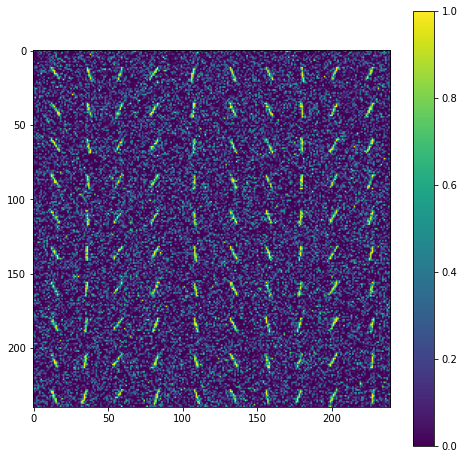

In [388]:
key = jr.split(key)[0]
data_id = 3#jr.choice(key, 100)
data = data_dict["train_data"][data_id]
# states = targets[data_id]
# angles = np.arctan2(states[:,0], states[:,1])
plot_img_grid(data)
plt.colorbar()

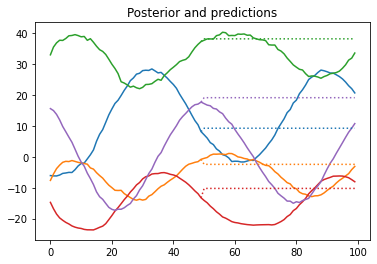

In [398]:
temp_params = deepcopy(run_params)
temp_params["mask_size"] = 0
out = model.elbo(jr.PRNGKey(0), data, params, **temp_params)
post_params = out["posterior_params"]
post_dist = model.posterior.distribution(post_params)
Ex = post_dist.mean()
A = prior_params["A"]
b = prior_params["b"]
T = 100
Ex_pred = predict_forward(Ex[T//2-1], A.T, b, T//2)
hs = plt.plot(Ex)
hs_ = plt.plot(np.arange(T//2-1, T), np.concatenate([Ex[T//2-1][None], Ex_pred]), linestyle=":")
plt.title("Posterior and predictions")
for i in range(len(hs)):
    hs_[i].set_color(hs[i].get_color())
# plt.figure()
# plot_pcs(Ex)
# plt.title("Posterior PCs")
# plt.figure()
# plt.plot(angles)
# plt.title("True pendulum angle")
# plt.plot((angles[1:]-angles[:-1])*20)

<Figure size 432x288 with 0 Axes>

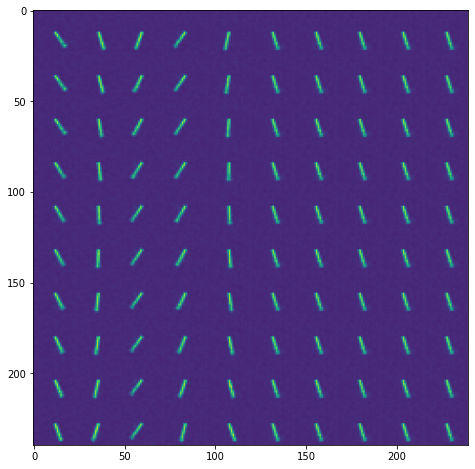

In [ ]:
out_dist = model.decoder.apply(dec_params, np.concatenate([Ex[:T//2], Ex_pred]))
y_decoded = out_dist.mean()
plt.figure()
plot_img_grid(y_decoded)

In [ ]:
targets = np.load("pendulum/pend_regression.npz")["train_targets"]

In [ ]:
states = targets[data_id][::2]
thetas = np.arctan2(states[:,0], states[:,1])
omegas = thetas[1:]-thetas[:-1]

In [ ]:
W_theta, _, _, _ = np.linalg.lstsq(Ex, thetas)
W_omega, _, _, _ = np.linalg.lstsq(Ex[1:], omegas)

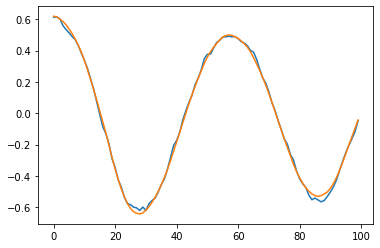

In [ ]:
plt.plot(Ex @ W_theta)
plt.plot(thetas)

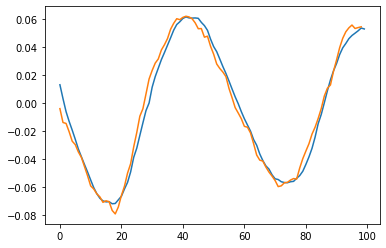

In [ ]:
plt.plot(Ex @ W_omega)
plt.plot(omegas)

# What is going on with the dynamics?

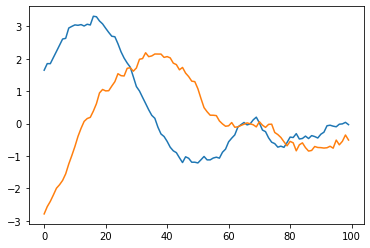

In [444]:
theta = 2 * np.pi / 100
lds_params = {
    "m1": np.zeros(2),
    "Q1": np.eye(2),
    "A": np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]),
    "Q": np.eye(2) / 100,
    "b": np.zeros(2)
}
prior = LinearGaussianChain(2, 100)
prior_dist = prior.distribution(prior.get_constrained_params(lds_params))
plt.plot(prior_dist.sample(seed=key_0))

In [401]:
temp_params = deepcopy(run_params)
temp_params["mask_size"] = 0
_, aux = svae_loss(key_0, model, data_dict["train_data"][:10], params, **temp_params)

In [402]:
pp = deepcopy(params["prior_params"])
suff_stats = aux["sufficient_statistics"]
pp["avg_suff_stats"] = suff_stats

In [403]:
fit_prior_params = model.prior.m_step(pp)
# fit_prior_params["A"] = scale_singular_values(fit_prior_params["A"])
# fit_prior_params["A"] = truncate_singular_values(fit_prior_params["A"])

In [379]:
key = key_0

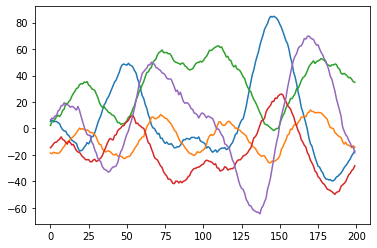

In [404]:
m1 = Q = fit_prior_params["m1"]
Q1 = fit_prior_params["Q1"]
Q = fit_prior_params["Q"]
A = fit_prior_params["A"]
b = fit_prior_params["b"]


x = jr.multivariate_normal(key=key, mean=m1, cov=Q1)
xs = []
for i in range(200):
    xs.append(x)
    key, _ = jr.split(key)
    noise = jr.multivariate_normal(key=key, mean=np.zeros_like(x), cov=Q)
    x = A @ x + b + noise

plt.plot(np.array(xs))

In [405]:
prior = LinearGaussianChain(model.prior.latent_dims, model.prior.seq_len)
prior_dist = prior.distribution(prior.get_constrained_params(fit_prior_params))

In [ ]:
Q = fit_prior_params["Q"]
A = fit_prior_params["A"]

In [406]:
sample = prior_dist.sample(seed=key_0)

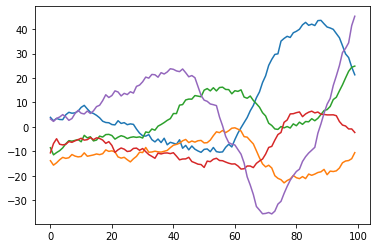

In [407]:
plt.plot(sample)